<a href="https://colab.research.google.com/github/SergeiVKalinin/MSE_Spring2024/blob/main/Module%202/17_Discovering_Kraichnan_orszag_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Notebook from: https://github.com/ShuaiGuo16/PINN_symbolic_regression
- Detailed walk-through is at: https://towardsdatascience.com/discovering-differential-equations-with-physics-informed-neural-networks-and-symbolic-regression-c28d279c0b4d
- Original paper is: https://arxiv.org/pdf/2307.08107.pdf

### Objective

In this notebook, we investigate combining PINN with symbolic regression to discover ODE systems. Our target ODE system can be written as follows:

\begin{align}
    \frac{du_1}{dt} &= e^{-t/10}u_2u_3 \\
    \frac{du_2}{dt} &= u_1u_3 \\
    \frac{du_3}{dt} &= -2u_1u_2 \\
\end{align}

with an initial condition of $u_1(0)=1, u_2(0)=0.8, u_3(0)=0.5$.

For our case study, we assume that we only know the right-hand side of the third equation to be a linear transformation of $u_1u_2$, and have no knowledge of the first two equations. Essentially, we can rewrite the ODE system as follows:

\begin{align}
    \frac{du_1}{dt} &= f_1(t, u_1, u_2, u_3) \\
    \frac{du_2}{dt} &= f_2(t, u_1, u_2, u_3) \\
    \frac{du_3}{dt} &= au_1u_2 + b \\
\end{align}

where $a, b$ are unknown coefficients and $f_1, f_2$ are the unknown functions. By using PINN and symbolic regression, we aim to calibrate the values of $a$ and $b$, as well as the functional forms of $f_1$ and $f_2$.

### 0. Import libraries

In [1]:
# Common packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from scipy.integrate import solve_ivp
from collections import defaultdict
import time

import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(42)

### 1. Observational data generation

To begin with, we need to generate simulation data of the investigated ODE system, which will be used later for inverse calibration.

In [2]:
def simulate_ODEs(u_init, t_span, obs_num):
    """Simulate the ODE system and obtain observational data.

    Args:
    ----
    u_init: list of initial condition for u1, u2, and u3
    t_span: lower and upper time limit for simulation
    obs_num: number of observational data points

    Outputs:
    --------
    u_obs: observed data for u's
    """

    # Define the target ODEs
    def odes(t, u):
        du1dt = np.exp(-t/10) * u[1] * u[2]
        du2dt = u[0] * u[2]
        du3dt = -2 * u[0] * u[1]
        return [du1dt, du2dt, du3dt]

    # Solve ODEs
    t_eval = np.linspace(t_span[0], t_span[1], obs_num)
    sol = solve_ivp(odes, t_span, u_init, method='RK45', t_eval=t_eval)

    # Restrcture obtained data
    u_obs = np.column_stack((sol.t, sol.y[0], sol.y[1], sol.y[2]))

    return u_obs

In [3]:
# Set up simulation
u_init = [1, 0.8, 0.5]
t_span = [0, 10]
obs_num = 1000

# Solve ODEs
u_obs = simulate_ODEs(u_init, t_span, obs_num)

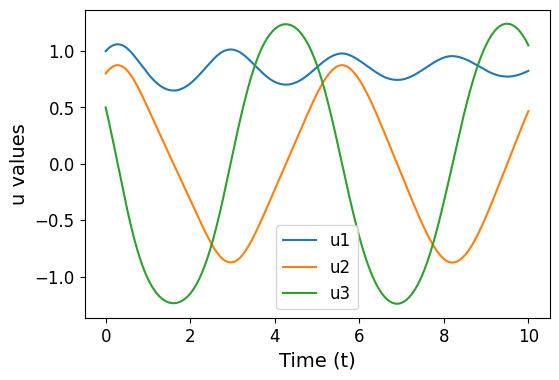

In [4]:
# Visualize the results
plt.figure(figsize=(6, 4))

plt.plot(u_obs[:, 0], u_obs[:, 1], label='u1')
plt.plot(u_obs[:, 0], u_obs[:, 2], label='u2')
plt.plot(u_obs[:, 0], u_obs[:, 3], label='u3')

plt.xlabel('Time (t)', fontsize=14)
plt.ylabel('u values', fontsize=14)
plt.tick_params(labelsize=12)
plt.legend(fontsize=12, frameon=True)

plt.savefig('u_profile.png', bbox_inches='tight', transparent=True)

### 2. Organize dataset

In [5]:
# Set batch size
data_batch_size = 100
ODE_batch_size = 1000

# Samples for enforcing data loss
X_train_data = tf.convert_to_tensor(u_obs[:, :1], dtype=tf.float32)
y_train_data = tf.convert_to_tensor(u_obs[:, 1:], dtype=tf.float32)
train_ds_data = tf.data.Dataset.from_tensor_slices((X_train_data, y_train_data))
train_ds_data = train_ds_data.shuffle(1000).batch(data_batch_size)

# Samples for enforcing ODE residual loss
N_collocation = 10000
X_train_ODE = tf.convert_to_tensor(np.linspace(0, 10, N_collocation).reshape(-1, 1), dtype=tf.float32)
train_ds_ODE = tf.data.Dataset.from_tensor_slices((X_train_ODE))
train_ds_ODE = train_ds_ODE.shuffle(10*N_collocation).batch(ODE_batch_size)

# Generate testing data
u_obs_test = simulate_ODEs(u_init, t_span, 5000)
X_test, y_test = u_obs_test[:, :1], u_obs_test[:, 1:]

### 3. Physics-informed Neural Networks

#### Define a custom layer for hosting unknown parameters

In [6]:
class ParameterLayer(tf.keras.layers.Layer):
    def __init__(self, a, b, trainable=True):
        super(ParameterLayer, self).__init__()
        self._a = tf.convert_to_tensor(a, dtype=tf.float32)
        self._b = tf.convert_to_tensor(b, dtype=tf.float32)
        self.trainable = trainable

    def build(self, input_shape):
        self.a = self.add_weight("a", shape=(1,),
                                 initializer=tf.keras.initializers.Constant(value=self._a),
                                 trainable=self.trainable)
        self.b = self.add_weight("b", shape=(1,),
                                 initializer=tf.keras.initializers.Constant(value=self._b),
                                 trainable=self.trainable)

    def get_config(self):
        return super().get_config()

    @classmethod
    def from_config(cls, config):
        return cls(**config)

#### Define Physics-informed Neural Network

In [7]:
def u_net(input_layer):
    """Definition of the network for u prediction."""

    hidden = input_layer
    for _ in range(2):
        hidden = tf.keras.layers.Dense(50, activation="tanh")(hidden)
    output = tf.keras.layers.Dense(3)(hidden)
    return output


def f_net(input_layers, a_init=None, b_init=None):
    """Definition of the network for f prediction."""

    hidden = tf.keras.layers.Concatenate()(input_layers)
    for _ in range(2):
        hidden = tf.keras.layers.Dense(50, activation="tanh")(hidden)
    output = tf.keras.layers.Dense(2)(hidden)
    output = ParameterLayer(a_init, b_init)(output)
    return output


def create_PINN(a_init=None, b_init=None, verbose=False):
    """Definition of a physics-informed neural network.

    Args:
    ----
    a_init: initial value for parameter a
    b_init: initial value for parameter b
    verbose: boolean, indicate whether to show the model summary

    Outputs:
    --------
    model: the PINN model
    """
    # Input
    t_input = tf.keras.Input(shape=(1,), name="time")

    # u-NN
    u = u_net(t_input)

    # f-NN
    f = f_net([t_input, u], a_init, b_init)

    # PINN model
    model = tf.keras.models.Model(inputs=t_input, outputs=[u, f])

    if verbose:
        model.summary()

    return model

#### ODE loss

In [8]:
@tf.function
def ODE_residual_calculator(t, model):
    """ODE residual calculation.

    Args:
    ----
    t: temporal coordinate
    model: PINN model

    Outputs:
    --------
    ODE_residual: residual of the governing ODE
    """

    # Retrieve parameters
    a = model.layers[-1].a
    b = model.layers[-1].b

    with tf.GradientTape() as tape:
        tape.watch(t)
        u, f = model(t)

    # Calculate gradients
    dudt = tape.batch_jacobian(u, t)[:, :, 0]
    du1_dt, du2_dt, du3_dt = dudt[:, :1], dudt[:, 1:2], dudt[:, 2:]

    # Compute residuals
    res1 = du1_dt - f[:, :1]
    res2 = du2_dt - f[:, 1:]
    res3 = du3_dt - (a*u[:, :1]*u[:, 1:2] + b)
    ODE_residual = tf.concat([res1, res2, res3], axis=1)

    return ODE_residual

#### Gradient descent step

In [9]:
@tf.function
def train_step(X_ODE, X, y, IC_weight, ODE_weight, data_weight, model):
    """Calculate gradients of the total loss with respect to network model parameters.

    Args:
    ----
    X_ODE: Collocation points for evaluating ODE residuals
    X: observed samples
    y: target values of the observed samples
    IC_weight: weight for initial condition loss
    ODE_weight: weight for ODE loss
    data_weight: weight for data loss
    model: PINN model

    Outputs:
    --------
    ODE_loss: calculated ODE loss
    IC_loss: calculated initial condition loss
    data_loss: calculated data loss
    total_loss: weighted sum of ODE loss, initial condition loss, and data loss
    gradients: gradients of the total loss with respect to network model parameters.
    """
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_weights)

        # Initial condition prediction
        y_pred_IC, _ = model(tf.zeros((1, 1)))

        # Equation residual
        ODE_residual = ODE_residual_calculator(t=X_ODE, model=model)

        # Data loss
        y_pred_data, _ = model(X)

        # Calculate loss
        IC_loss = tf.reduce_mean(keras.losses.mean_squared_error(tf.constant([[1.0, 0.8, 0.5]]), y_pred_IC))
        ODE_loss = tf.reduce_mean(tf.square(ODE_residual))
        data_loss = tf.reduce_mean(keras.losses.mean_squared_error(y, y_pred_data))

        # Weight loss
        total_loss = IC_loss*IC_weight + ODE_loss*ODE_weight + data_loss*data_weight

    gradients = tape.gradient(total_loss, model.trainable_variables)

    return ODE_loss, IC_loss, data_loss, total_loss, gradients

#### Define loss tracking class

In [10]:
class LossTracking:

    def __init__(self):
        self.mean_total_loss = keras.metrics.Mean()
        self.mean_IC_loss = keras.metrics.Mean()
        self.mean_ODE_loss = keras.metrics.Mean()
        self.mean_data_loss = keras.metrics.Mean()
        self.loss_history = defaultdict(list)

    def update(self, total_loss, IC_loss, ODE_loss, data_loss):
        self.mean_total_loss(total_loss)
        self.mean_IC_loss(IC_loss)
        self.mean_ODE_loss(ODE_loss)
        self.mean_data_loss(data_loss)

    def reset(self):
        self.mean_total_loss.reset_states()
        self.mean_IC_loss.reset_states()
        self.mean_ODE_loss.reset_states()
        self.mean_data_loss.reset_states()

    def print(self):
        print(f"IC={self.mean_IC_loss.result().numpy():.4e}, \
              ODE={self.mean_ODE_loss.result().numpy():.4e}, \
              data={self.mean_data_loss.result().numpy():.4e}, \
              total_loss={self.mean_total_loss.result().numpy():.4e}")

    def history(self):
        self.loss_history['total_loss'].append(self.mean_total_loss.result().numpy())
        self.loss_history['IC_loss'].append(self.mean_IC_loss.result().numpy())
        self.loss_history['ODE_loss'].append(self.mean_ODE_loss.result().numpy())
        self.loss_history['Data_loss'].append(self.mean_data_loss.result().numpy())

#### Define callback

In [11]:
class PrintParameters(keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        print(f"\na: {self.model.layers[-1].a.numpy()}, b: {self.model.layers[-1].b.numpy()}")

#### Training

In [12]:
# Set up training configurations
n_epochs = 1000
IC_weight= tf.constant(1.0, dtype=tf.float32)
ODE_weight= tf.constant(1.0, dtype=tf.float32)
data_weight= tf.constant(1.0, dtype=tf.float32)
loss_tracker = LossTracking()
val_loss_hist = []
a_list, b_list = [], []

# Initial value for unknown parameters
a_init, b_init = -1, 1

# Set up optimizer
optimizer = keras.optimizers.Adam(learning_rate=2e-2)

with tf.device("CPU:0"):

    # Instantiate the PINN model
    PINN = create_PINN(a_init=a_init, b_init=b_init)
    PINN.compile(optimizer=optimizer)

    # Configure callbacks
    _callbacks = [keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=100),
                 tf.keras.callbacks.ModelCheckpoint('PINN_model.h5', monitor='val_loss', save_best_only=True),
                 PrintParameters()]
    callbacks = tf.keras.callbacks.CallbackList(
                    _callbacks, add_history=False, model=PINN)

    # Start training process
    for epoch in range(1, n_epochs + 1):
        print(f"Epoch {epoch}:")

        for (X_ODE), (X, y) in zip(train_ds_ODE, train_ds_data):

            # Calculate gradients
            ODE_loss, IC_loss, data_loss, total_loss, gradients = train_step(X_ODE, X, y, IC_weight,
                                                                             ODE_weight, data_weight, PINN)
            # Gradient descent
            PINN.optimizer.apply_gradients(zip(gradients, PINN.trainable_variables))

            # Loss tracking
            loss_tracker.update(total_loss, IC_loss, ODE_loss, data_loss)

        # Loss summary
        loss_tracker.history()
        loss_tracker.print()
        loss_tracker.reset()

        # Parameter recording
        a_list.append(PINN.layers[-1].a.numpy())
        b_list.append(PINN.layers[-1].b.numpy())

        ####### Validation
        val_res = ODE_residual_calculator(tf.reshape(tf.linspace(0.0, 10.0, 1000), [-1, 1]), PINN)
        val_ODE = tf.cast(tf.reduce_mean(tf.square(val_res)), tf.float32)

        u_init=tf.constant([[1.0, 0.8, 0.5]])
        val_pred_init, _ = PINN.predict(tf.zeros((1, 1)))
        val_IC = tf.reduce_mean(tf.square(val_pred_init - u_init))
        print(f"val_IC: {val_IC.numpy():.4e}, val_ODE: {val_ODE.numpy():.4e}, lr: {PINN.optimizer.lr.numpy():.2e}")

        # Callback at the end of epoch
        callbacks.on_epoch_end(epoch, logs={'val_loss': val_IC+val_ODE})
        val_loss_hist.append(val_IC+val_ODE)

        # Test dataset
        pred_test, _ = PINN.predict(X_test, batch_size=12800)
        print(f"RMSE: {mean_squared_error(y_test.flatten(), pred_test.flatten(), squared=False)}")


        # Re-shuffle dataset
        train_ds_data = tf.data.Dataset.from_tensor_slices((X_train_data, y_train_data))
        train_ds_data = train_ds_data.shuffle(10000).batch(data_batch_size)

        train_ds_ODE = tf.data.Dataset.from_tensor_slices((X_train_ODE))
        train_ds_ODE = train_ds_ODE.shuffle(10*N_collocation).batch(ODE_batch_size)

Epoch 1:
IC=1.8311e-01,               ODE=1.1178e+00,               data=2.0604e+00,               total_loss=3.3614e+00
1/1 [==============================] - 1s 646ms/step
val_IC: 8.0284e-02, val_ODE: 6.2069e-02, lr: 2.00e-02

a: [-0.91459167], b: [0.84386784]


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 147ms/step
RMSE: 1.1092809147618323
Epoch 2:
IC=6.6242e-02,               ODE=2.0240e-01,               data=6.5691e-01,               total_loss=9.2555e-01
1/1 [==============================] - 0s 36ms/step
val_IC: 1.7574e-02, val_ODE: 1.5573e-01, lr: 2.00e-02

a: [-0.86703265], b: [0.7309146]
1/1 [==============================] - 0s 67ms/step
RMSE: 0.7832820487556227
Epoch 3:
IC=8.3233e-03,               ODE=8.2483e-02,               data=5.2726e-01,               total_loss=6.1806e-01
1/1 [==============================] - 0s 48ms/step
val_IC: 2.8140e-03, val_ODE: 4.2431e-02, lr: 2.00e-02

a: [-0.85736495], b: [0.60960954]


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 82ms/step
RMSE: 0.720868311024897
Epoch 4:
IC=3.3327e-03,               ODE=5.3837e-02,               data=4.3521e-01,               total_loss=4.9238e-01
1/1 [==============================] - 0s 92ms/step
val_IC: 5.7088e-03, val_ODE: 4.4260e-02, lr: 2.00e-02

a: [-0.86800086], b: [0.50513315]
1/1 [==============================] - 0s 38ms/step
RMSE: 0.6312579155037701
Epoch 5:
IC=8.3678e-03,               ODE=4.1908e-02,               data=3.7453e-01,               total_loss=4.2480e-01
1/1 [==============================] - 0s 67ms/step
val_IC: 7.3148e-03, val_ODE: 2.7505e-02, lr: 2.00e-02

a: [-0.8833454], b: [0.40319037]


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 104ms/step
RMSE: 0.6003962042850611
Epoch 6:
IC=2.9404e-03,               ODE=2.8838e-02,               data=3.5394e-01,               total_loss=3.8572e-01
1/1 [==============================] - 0s 28ms/step
val_IC: 9.9896e-04, val_ODE: 2.9538e-02, lr: 2.00e-02

a: [-0.89927036], b: [0.3118494]
1/1 [==============================] - 0s 29ms/step
RMSE: 0.5826759589545345
Epoch 7:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.0138e-03,               ODE=2.2132e-02,               data=3.3951e-01,               total_loss=3.6466e-01
1/1 [==============================] - 0s 20ms/step
val_IC: 3.7848e-03, val_ODE: 2.2942e-02, lr: 2.00e-02

a: [-0.91411334], b: [0.23034337]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.575391951984167
Epoch 8:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.8654e-03,               ODE=1.8546e-02,               data=3.3093e-01,               total_loss=3.5234e-01
1/1 [==============================] - 0s 23ms/step
val_IC: 1.7080e-03, val_ODE: 1.9950e-02, lr: 2.00e-02

a: [-0.9277191], b: [0.16122337]
1/1 [==============================] - 0s 30ms/step
RMSE: 0.5727680392049598
Epoch 9:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.5982e-03,               ODE=1.4440e-02,               data=3.2807e-01,               total_loss=3.4411e-01
1/1 [==============================] - 0s 24ms/step
val_IC: 2.0172e-03, val_ODE: 1.6276e-02, lr: 2.00e-02

a: [-0.9397909], b: [0.10407896]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.5671426346564457
Epoch 10:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.9782e-03,               ODE=1.3347e-02,               data=3.2442e-01,               total_loss=3.3974e-01
1/1 [==============================] - 0s 21ms/step
val_IC: 2.3389e-03, val_ODE: 9.2452e-03, lr: 2.00e-02

a: [-0.9508367], b: [0.0571215]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.5683669784848819
Epoch 11:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.5767e-03,               ODE=1.0889e-02,               data=3.2399e-01,               total_loss=3.3645e-01
1/1 [==============================] - 0s 22ms/step
val_IC: 1.7371e-03, val_ODE: 1.1452e-02, lr: 2.00e-02

a: [-0.96108323], b: [0.02307638]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.5631324920040532
Epoch 12:
IC=1.8511e-03,               ODE=1.0735e-02,               data=3.1979e-01,               total_loss=3.3237e-01
1/1 [==============================] - 0s 27ms/step
val_IC: 5.7062e-04, val_ODE: 1.0211e-02, lr: 2.00e-02

a: [-0.97140735], b: [-0.00230208]
1/1 [==============================] - 0s 30ms/step
RMSE: 0.5617083784367436
Epoch 13:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.2854e-03,               ODE=1.1513e-02,               data=3.1670e-01,               total_loss=3.2950e-01
1/1 [==============================] - 0s 22ms/step
val_IC: 1.5517e-03, val_ODE: 9.4637e-03, lr: 2.00e-02

a: [-0.9817926], b: [-0.01961468]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.5587996538920483
Epoch 14:
IC=1.5341e-03,               ODE=1.0807e-02,               data=3.1485e-01,               total_loss=3.2719e-01
1/1 [==============================] - 0s 28ms/step
val_IC: 3.0232e-04, val_ODE: 1.1158e-02, lr: 2.00e-02

a: [-0.9922949], b: [-0.02988543]
1/1 [==============================] - 0s 41ms/step
RMSE: 0.5603707903909447
Epoch 15:
IC=3.0504e-03,               ODE=1.2167e-02,               data=3.1606e-01,               total_loss=3.3128e-01
1/1 [==============================] - 0s 21ms/step
val_IC: 1.5676e-04, val_ODE: 1.2396e-02, lr: 2.00e-02

a: [-1.003063], b: [-0.041054]
1/1 [==============================] - 0s 33ms/step
RMSE: 0.5602286745

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.5432516093102933
Epoch 20:
IC=8.6370e-04,               ODE=1.3929e-02,               data=2.9462e-01,               total_loss=3.0942e-01
1/1 [==============================] - 0s 22ms/step
val_IC: 1.5633e-03, val_ODE: 7.3464e-03, lr: 2.00e-02

a: [-1.0667987], b: [-0.04500891]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.5390509536173174
Epoch 21:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0906e-03,               ODE=9.5333e-03,               data=2.9032e-01,               total_loss=3.0094e-01
1/1 [==============================] - 0s 21ms/step
val_IC: 3.1721e-03, val_ODE: 6.9762e-03, lr: 2.00e-02

a: [-1.0811166], b: [-0.04230371]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.5354671006847115
Epoch 22:
IC=1.2400e-03,               ODE=7.4013e-03,               data=2.8328e-01,               total_loss=2.9192e-01
1/1 [==============================] - 0s 20ms/step
val_IC: 2.5050e-03, val_ODE: 8.0407e-03, lr: 2.00e-02

a: [-1.096041], b: [-0.03579605]
1/1 [==============================] - 0s 29ms/step
RMSE: 0.5402586126848083
Epoch 23:
IC=2.4715e-03,               ODE=9.1112e-03,               data=2.8415e-01,               total_loss=2.9573e-01
1/1 [==============================] - 0s 20ms/step
val_IC: 1.2107e-03, val_ODE: 1.0593e-02, lr: 2.00e-02

a: [-1.1104987], b: [-0.03461592]
1/1 [==============================] - 0s 31ms/step
RMSE: 0.52738295

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.0888e-04,               ODE=7.8020e-03,               data=2.6728e-02,               total_loss=3.5139e-02
1/1 [==============================] - 0s 21ms/step
val_IC: 2.5755e-04, val_ODE: 6.1747e-03, lr: 2.00e-02

a: [-1.7020042], b: [0.0641787]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.15451750287341587
Epoch 49:
IC=9.0610e-04,               ODE=8.6222e-03,               data=2.4093e-02,               total_loss=3.3621e-02
1/1 [==============================] - 0s 21ms/step
val_IC: 3.4458e-04, val_ODE: 7.8247e-03, lr: 2.00e-02

a: [-1.7248597], b: [0.06354418]
1/1 [==============================] - 0s 33ms/step
RMSE: 0.15061994559227831
Epoch 50:
IC=7.5640e-04,               ODE=6.8924e-03,               data=2.2758e-02,               total_loss=3.0407e-02
1/1 [==============================] - 0s 21ms/step
val_IC: 5.1797e-04, val_ODE: 6.7136e-03, lr: 2.00e-02

a: [-1.7460481], b: [0.06160576]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.156419417

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.7501e-04,               ODE=4.4046e-03,               data=1.5383e-02,               total_loss=2.0363e-02
1/1 [==============================] - 0s 35ms/step
val_IC: 5.2904e-04, val_ODE: 3.3338e-03, lr: 2.00e-02

a: [-1.7845991], b: [0.05656564]
1/1 [==============================] - 0s 48ms/step
RMSE: 0.12329609325334191
Epoch 53:
IC=4.1964e-04,               ODE=3.0316e-03,               data=1.4120e-02,               total_loss=1.7571e-02
1/1 [==============================] - 0s 21ms/step
val_IC: 6.9612e-04, val_ODE: 4.2479e-03, lr: 2.00e-02

a: [-1.802242], b: [0.05473738]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.11250090920673153
Epoch 54:
IC=5.8322e-04,               ODE=3.1742e-03,               data=1.3087e-02,               total_loss=1.6844e-02
1/1 [==============================] - 0s 22ms/step
val_IC: 8.4263e-04, val_ODE: 3.1502e-03, lr: 2.00e-02

a: [-1.8184364], b: [0.05280132]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.116203186

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.6435e-04,               ODE=1.6539e-03,               data=1.0706e-02,               total_loss=1.2625e-02
1/1 [==============================] - 0s 23ms/step
val_IC: 1.6501e-04, val_ODE: 1.6193e-03, lr: 2.00e-02

a: [-1.8478214], b: [0.05034304]
1/1 [==============================] - 0s 27ms/step
RMSE: 0.10319272946744881
Epoch 57:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1966e-04,               ODE=1.6463e-03,               data=1.0116e-02,               total_loss=1.1881e-02
1/1 [==============================] - 0s 21ms/step
val_IC: 1.6458e-04, val_ODE: 9.7292e-04, lr: 2.00e-02

a: [-1.8618715], b: [0.04920726]
1/1 [==============================] - 0s 34ms/step
RMSE: 0.09882875904422227
Epoch 58:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4027e-04,               ODE=1.2817e-03,               data=9.3087e-03,               total_loss=1.0731e-02
1/1 [==============================] - 0s 21ms/step
val_IC: 6.3586e-05, val_ODE: 1.2854e-03, lr: 2.00e-02

a: [-1.8749394], b: [0.04769534]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.0947200100969282
Epoch 59:
IC=1.0520e-04,               ODE=1.3009e-03,               data=9.1949e-03,               total_loss=1.0601e-02
1/1 [==============================] - 0s 20ms/step
val_IC: 6.5110e-04, val_ODE: 1.1270e-03, lr: 2.00e-02

a: [-1.8873786], b: [0.04733246]
1/1 [==============================] - 0s 27ms/step
RMSE: 0.09336856505618957
Epoch 60:
IC=2.8606e-04,               ODE=1.3780e-03,               data=8.7893e-03,               total_loss=1.0453e-02
1/1 [==============================] - 0s 32ms/step
val_IC: 6.3432e-04, val_ODE: 1.9027e-03, lr: 2.00e-02

a: [-1.8985666], b: [0.04645601]
1/1 [==============================] - 0s 40ms/step
RMSE: 0.094001400

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.9111e-04,               ODE=2.5937e-03,               data=6.4201e-03,               total_loss=9.5050e-03
1/1 [==============================] - 0s 21ms/step
val_IC: 9.1961e-04, val_ODE: 2.3534e-03, lr: 2.00e-02

a: [-1.9640191], b: [0.04147082]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.08028771176558984
Epoch 69:
IC=3.5991e-04,               ODE=1.8815e-03,               data=6.2038e-03,               total_loss=8.4452e-03
1/1 [==============================] - 0s 23ms/step
val_IC: 3.3457e-04, val_ODE: 2.2223e-03, lr: 2.00e-02

a: [-1.9697257], b: [0.04078675]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.07595363707419742
Epoch 70:
IC=2.9129e-04,               ODE=1.5571e-03,               data=5.9467e-03,               total_loss=7.7951e-03
1/1 [==============================] - 0s 24ms/step
val_IC: 9.0409e-05, val_ODE: 1.0484e-03, lr: 2.00e-02

a: [-1.974614], b: [0.04030545]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.071851786

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 77:
IC=9.8379e-04,               ODE=3.7431e-03,               data=5.2891e-03,               total_loss=1.0016e-02
1/1 [==============================] - 0s 102ms/step
val_IC: 1.3422e-03, val_ODE: 4.1043e-03, lr: 2.00e-02

a: [-1.9993498], b: [0.03729029]
1/1 [==============================] - 0s 36ms/step
RMSE: 0.07675123506314308
Epoch 78:
IC=1.1896e-03,               ODE=4.6877e-03,               data=5.4108e-03,               total_loss=1.1288e-02
1/1 [==============================] - 0s 37ms/step
val_IC: 1.9967e-03, val_ODE: 5.5147e-03, lr: 2.00e-02

a: [-1.9999338], b: [0.0372407]
1/1 [==============================] - 0s 39ms/step
RMSE: 0.07554317051780089
Epoch 79:
IC=1.1338e-03,               ODE=3.2294e-03,               data=4.5650e-03,               total_loss=8.9282e-03
1/1 [==============================] - 0s 20ms/step
val_IC: 4.1382e-04, val_ODE: 3.1746e-03, lr: 2.00e-02

a: [-1.999865], b: [0.03661]
1/1 [==============================] - 0s 27ms/step
RMSE: 0.06

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.6225e-04,               ODE=1.0044e-03,               data=3.8476e-03,               total_loss=5.0142e-03
1/1 [==============================] - 0s 22ms/step
val_IC: 5.4036e-05, val_ODE: 1.3975e-03, lr: 2.00e-02

a: [-2.004147], b: [0.03525011]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.059959333455566075
Epoch 82:
IC=2.5915e-04,               ODE=1.5333e-03,               data=3.8613e-03,               total_loss=5.6538e-03
1/1 [==============================] - 0s 21ms/step
val_IC: 6.1811e-04, val_ODE: 2.3207e-03, lr: 2.00e-02

a: [-2.0071106], b: [0.03499047]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.06260725955943185
Epoch 83:
IC=1.8227e-04,               ODE=1.1767e-03,               data=3.5367e-03,               total_loss=4.8956e-03
1/1 [==============================] - 0s 21ms/step
val_IC: 1.7403e-05, val_ODE: 1.0130e-03, lr: 2.00e-02

a: [-2.0098107], b: [0.0342346]
1/1 [==============================] - 0s 33ms/step
RMSE: 0.056306382

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.6697e-04,               ODE=1.7295e-03,               data=3.3116e-03,               total_loss=5.2081e-03
1/1 [==============================] - 0s 20ms/step
val_IC: 2.2797e-04, val_ODE: 7.8834e-04, lr: 2.00e-02

a: [-2.0158942], b: [0.03206239]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.05708427549897186
Epoch 88:
IC=1.6697e-04,               ODE=9.2305e-04,               data=3.0454e-03,               total_loss=4.1354e-03
1/1 [==============================] - 0s 20ms/step
val_IC: 8.0697e-05, val_ODE: 8.3119e-04, lr: 2.00e-02

a: [-2.0171971], b: [0.03126732]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.051836751122317386
Epoch 89:
IC=1.3556e-04,               ODE=9.6698e-04,               data=2.8237e-03,               total_loss=3.9262e-03
1/1 [==============================] - 0s 22ms/step
val_IC: 6.4237e-05, val_ODE: 7.1504e-04, lr: 2.00e-02

a: [-2.0186553], b: [0.0300624]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.05130563

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.8463e-05,               ODE=6.4066e-04,               data=2.3460e-03,               total_loss=3.0751e-03
1/1 [==============================] - 0s 26ms/step
val_IC: 6.1062e-05, val_ODE: 1.2419e-03, lr: 2.00e-02

a: [-2.0227985], b: [0.02831588]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.04839471904510424
Epoch 93:
IC=1.2584e-04,               ODE=1.0065e-03,               data=2.5309e-03,               total_loss=3.6633e-03
1/1 [==============================] - 0s 33ms/step
val_IC: 2.1780e-04, val_ODE: 1.3697e-03, lr: 2.00e-02

a: [-2.023596], b: [0.02761138]
1/1 [==============================] - 0s 37ms/step
RMSE: 0.047791108697644
Epoch 94:
IC=2.7212e-04,               ODE=1.3966e-03,               data=2.4379e-03,               total_loss=4.1066e-03
1/1 [==============================] - 0s 32ms/step
val_IC: 7.0430e-04, val_ODE: 1.7664e-03, lr: 2.00e-02

a: [-2.0242872], b: [0.02645862]
1/1 [==============================] - 0s 43ms/step
RMSE: 0.05060979602

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.7506e-05,               ODE=8.3358e-04,               data=1.1176e-03,               total_loss=2.0486e-03
1/1 [==============================] - 0s 24ms/step
val_IC: 1.2361e-04, val_ODE: 9.0850e-04, lr: 2.00e-02

a: [-2.0109565], b: [0.01096816]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.03134489295588384
Epoch 118:
IC=1.2009e-04,               ODE=8.5992e-04,               data=8.9026e-04,               total_loss=1.8703e-03
1/1 [==============================] - 0s 21ms/step
val_IC: 4.9937e-05, val_ODE: 3.0865e-04, lr: 2.00e-02

a: [-2.0115142], b: [0.01058574]
1/1 [==============================] - 0s 28ms/step
RMSE: 0.026435649805373204
Epoch 119:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.2573e-05,               ODE=7.2307e-04,               data=8.8561e-04,               total_loss=1.6913e-03
1/1 [==============================] - 0s 23ms/step
val_IC: 1.2173e-04, val_ODE: 1.6888e-03, lr: 2.00e-02

a: [-2.0121455], b: [0.00993916]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.03951903713677198
Epoch 120:
IC=6.1184e-05,               ODE=8.7671e-04,               data=9.2304e-04,               total_loss=1.8609e-03
1/1 [==============================] - 0s 22ms/step
val_IC: 2.4924e-05, val_ODE: 6.5298e-04, lr: 2.00e-02

a: [-2.0126846], b: [0.01010177]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.029775495298537055
Epoch 121:
IC=2.4338e-04,               ODE=1.4665e-03,               data=1.1583e-03,               total_loss=2.8682e-03
1/1 [==============================] - 0s 21ms/step
val_IC: 3.8617e-04, val_ODE: 1.8957e-03, lr: 2.00e-02

a: [-2.0133219], b: [0.00999154]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.03294

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0286e-04,               ODE=6.5514e-04,               data=5.6546e-04,               total_loss=1.3235e-03
1/1 [==============================] - 0s 21ms/step
val_IC: 1.2149e-04, val_ODE: 1.1992e-03, lr: 2.00e-02

a: [-1.9971547], b: [0.00094538]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.05252011844096852
Epoch 215:
IC=4.9931e-04,               ODE=2.0586e-03,               data=1.1200e-03,               total_loss=3.6779e-03
1/1 [==============================] - 0s 20ms/step
val_IC: 1.0434e-03, val_ODE: 3.6342e-03, lr: 2.00e-02

a: [-1.9972411], b: [0.00253601]
1/1 [==============================] - 0s 31ms/step
RMSE: 0.038747827064865556
Epoch 216:
IC=2.7068e-04,               ODE=2.0569e-03,               data=7.8711e-04,               total_loss=3.1146e-03
1/1 [==============================] - 0s 20ms/step
val_IC: 2.5487e-04, val_ODE: 1.7575e-03, lr: 2.00e-02

a: [-1.995478], b: [0.00269136]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.056028

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.6629e-05,               ODE=3.0455e-04,               data=2.9125e-04,               total_loss=6.4243e-04
1/1 [==============================] - 0s 20ms/step
val_IC: 6.7137e-05, val_ODE: 2.9412e-04, lr: 1.00e-02

a: [-1.9942687], b: [0.00136516]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.014633850265638721
Epoch 222:
IC=2.9527e-05,               ODE=2.5981e-04,               data=1.9278e-04,               total_loss=4.8212e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 3.5727e-06, val_ODE: 2.2583e-04, lr: 1.00e-02

a: [-1.9955032], b: [0.00148988]
1/1 [==============================] - 0s 29ms/step
RMSE: 0.013603838432695152
Epoch 223:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.5394e-06,               ODE=2.2699e-04,               data=1.8474e-04,               total_loss=4.2127e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 4.5437e-06, val_ODE: 2.4649e-04, lr: 1.00e-02

a: [-1.9967046], b: [0.00156456]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.013324440406438015
Epoch 224:
IC=6.3106e-06,               ODE=2.2007e-04,               data=1.8306e-04,               total_loss=4.0944e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 5.2618e-06, val_ODE: 2.0062e-04, lr: 1.00e-02

a: [-1.9978734], b: [0.00157772]
1/1 [==============================] - 0s 28ms/step
RMSE: 0.013656489875804291
Epoch 225:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.4523e-06,               ODE=2.2583e-04,               data=1.7917e-04,               total_loss=4.0945e-04
1/1 [==============================] - 0s 20ms/step
val_IC: 5.7107e-08, val_ODE: 2.0534e-04, lr: 1.00e-02

a: [-1.9988718], b: [0.00150484]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.012868356855247665
Epoch 226:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.5235e-06,               ODE=2.2073e-04,               data=1.7866e-04,               total_loss=4.0191e-04
1/1 [==============================] - 0s 20ms/step
val_IC: 1.0284e-06, val_ODE: 2.3618e-04, lr: 1.00e-02

a: [-1.9998244], b: [0.00150858]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.013372072647305304
Epoch 227:
IC=2.2026e-06,               ODE=2.1275e-04,               data=1.7968e-04,               total_loss=3.9464e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 9.4598e-07, val_ODE: 2.0748e-04, lr: 1.00e-02

a: [-2.000628], b: [0.00134211]
1/1 [==============================] - 0s 27ms/step
RMSE: 0.012571449024733375
Epoch 228:
IC=2.0444e-06,               ODE=2.0687e-04,               data=1.6330e-04,               total_loss=3.7221e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 3.4901e-06, val_ODE: 2.1041e-04, lr: 1.00e-02

a: [-2.001393], b: [0.00126336]
1/1 [==============================] - 0s 28ms/step
RMSE: 0.012517

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3042e-06,               ODE=1.9433e-04,               data=1.5757e-04,               total_loss=3.5320e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 1.1123e-06, val_ODE: 2.0941e-04, lr: 1.00e-02

a: [-2.0038564], b: [0.00130126]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.012574766172263224
Epoch 233:
IC=2.6499e-06,               ODE=2.0131e-04,               data=1.5901e-04,               total_loss=3.6297e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 1.2847e-07, val_ODE: 1.9889e-04, lr: 1.00e-02

a: [-2.0044103], b: [0.00128434]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.012372532737317985
Epoch 234:
IC=3.7221e-06,               ODE=2.0085e-04,               data=1.6332e-04,               total_loss=3.6789e-04
1/1 [==============================] - 0s 30ms/step
val_IC: 5.2342e-06, val_ODE: 1.9472e-04, lr: 1.00e-02

a: [-2.0049253], b: [0.00125152]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.0135

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.1378e-06,               ODE=1.9217e-04,               data=1.5586e-04,               total_loss=3.5218e-04
1/1 [==============================] - 0s 19ms/step
val_IC: 2.0291e-06, val_ODE: 1.8414e-04, lr: 1.00e-02

a: [-2.0068312], b: [0.00121437]
1/1 [==============================] - 0s 29ms/step
RMSE: 0.013619596469343225
Epoch 240:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.5328e-06,               ODE=1.9402e-04,               data=1.7309e-04,               total_loss=3.7064e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 2.9414e-06, val_ODE: 2.0991e-04, lr: 1.00e-02

a: [-2.0071328], b: [0.00122557]
1/1 [==============================] - 0s 39ms/step
RMSE: 0.012488315022661154
Epoch 241:
IC=6.9785e-06,               ODE=2.0354e-04,               data=1.6059e-04,               total_loss=3.7111e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 2.5581e-06, val_ODE: 2.0517e-04, lr: 1.00e-02

a: [-2.0074797], b: [0.0011364]
1/1 [==============================] - 0s 29ms/step
RMSE: 0.012470387632696379
Epoch 242:
IC=3.6393e-06,               ODE=2.0032e-04,               data=1.6301e-04,               total_loss=3.6697e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 5.7872e-06, val_ODE: 2.0309e-04, lr: 1.00e-02

a: [-2.0077307], b: [0.00112563]
1/1 [==============================] - 0s 43ms/step
RMSE: 0.01286

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.1942e-06,               ODE=1.9639e-04,               data=1.5135e-04,               total_loss=3.5194e-04
1/1 [==============================] - 0s 30ms/step
val_IC: 6.1525e-06, val_ODE: 1.7888e-04, lr: 1.00e-02

a: [-2.0087922], b: [0.00096554]
1/1 [==============================] - 0s 38ms/step
RMSE: 0.012665344242385608
Epoch 252:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.1962e-06,               ODE=2.0771e-04,               data=1.6813e-04,               total_loss=3.8004e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 1.4314e-05, val_ODE: 2.0565e-04, lr: 1.00e-02

a: [-2.0088596], b: [0.00123659]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.012271696523240118
Epoch 253:
IC=1.1139e-05,               ODE=2.1208e-04,               data=1.5614e-04,               total_loss=3.7936e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 2.8393e-05, val_ODE: 1.9166e-04, lr: 1.00e-02

a: [-2.0088458], b: [0.00118781]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.014201639300829587
Epoch 254:
IC=1.1878e-05,               ODE=1.9758e-04,               data=1.5864e-04,               total_loss=3.6809e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 1.0748e-05, val_ODE: 2.1240e-04, lr: 1.00e-02

a: [-2.0088978], b: [0.00103361]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.0118

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.0864e-06,               ODE=1.8206e-04,               data=1.4789e-04,               total_loss=3.3403e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 1.9220e-06, val_ODE: 1.9169e-04, lr: 1.00e-02

a: [-2.0089548], b: [0.00095947]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.011620617330857745
Epoch 259:
IC=4.4099e-06,               ODE=1.8126e-04,               data=1.4670e-04,               total_loss=3.3237e-04
1/1 [==============================] - 0s 35ms/step
val_IC: 4.9122e-06, val_ODE: 1.8781e-04, lr: 1.00e-02

a: [-2.0090141], b: [0.00091778]
1/1 [==============================] - 0s 45ms/step
RMSE: 0.012080366769996836
Epoch 260:
IC=2.9794e-06,               ODE=1.8049e-04,               data=1.5674e-04,               total_loss=3.4021e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 7.1026e-07, val_ODE: 1.9508e-04, lr: 1.00e-02

a: [-2.0090458], b: [0.00089186]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.0123

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.2890e-06,               ODE=1.6511e-04,               data=1.3934e-04,               total_loss=3.0674e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 1.3105e-05, val_ODE: 1.9917e-04, lr: 1.00e-02

a: [-2.0087214], b: [0.00085644]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.01205812837860207
Epoch 277:
IC=1.0940e-05,               ODE=1.7966e-04,               data=1.3782e-04,               total_loss=3.2841e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 7.6273e-06, val_ODE: 1.7567e-04, lr: 1.00e-02

a: [-2.008652], b: [0.00081669]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.011790710817466127
Epoch 278:
IC=5.1397e-06,               ODE=1.7447e-04,               data=1.4731e-04,               total_loss=3.2692e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 1.2141e-05, val_ODE: 1.6264e-04, lr: 1.00e-02

a: [-2.0086215], b: [0.00086185]
1/1 [==============================] - 0s 32ms/step
RMSE: 0.012599

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.4238e-06,               ODE=1.7088e-04,               data=1.3343e-04,               total_loss=3.1073e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 3.0817e-06, val_ODE: 1.8635e-04, lr: 1.00e-02

a: [-2.008422], b: [0.00085515]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.011737758210850272
Epoch 281:
IC=6.0395e-06,               ODE=1.6652e-04,               data=1.3671e-04,               total_loss=3.0928e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 2.0583e-05, val_ODE: 1.8576e-04, lr: 1.00e-02

a: [-2.008398], b: [0.00070085]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.011957877709203845
Epoch 282:
IC=5.6020e-06,               ODE=1.6550e-04,               data=1.3406e-04,               total_loss=3.0515e-04
1/1 [==============================] - 0s 25ms/step
val_IC: 1.2729e-06, val_ODE: 1.7338e-04, lr: 1.00e-02

a: [-2.0083869], b: [0.00083557]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.012024

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.3133e-06,               ODE=1.6211e-04,               data=1.2851e-04,               total_loss=2.9393e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 5.4887e-06, val_ODE: 1.6789e-04, lr: 1.00e-02

a: [-2.008354], b: [0.00107401]
1/1 [==============================] - 0s 28ms/step
RMSE: 0.010951849564763807
Epoch 286:
IC=2.0138e-06,               ODE=1.5928e-04,               data=1.2952e-04,               total_loss=2.9081e-04
1/1 [==============================] - 0s 20ms/step
val_IC: 4.3766e-06, val_ODE: 1.4945e-04, lr: 1.00e-02

a: [-2.0083432], b: [0.00106908]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.010848665723016645
Epoch 287:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.5640e-06,               ODE=1.8378e-04,               data=2.6432e-04,               total_loss=4.5366e-04
1/1 [==============================] - 0s 24ms/step
val_IC: 2.1577e-05, val_ODE: 1.7743e-04, lr: 1.00e-02

a: [-2.0081525], b: [0.00076326]
1/1 [==============================] - 0s 43ms/step
RMSE: 0.01840797815614598
Epoch 288:
IC=2.6163e-05,               ODE=2.1506e-04,               data=2.1959e-04,               total_loss=4.6082e-04
1/1 [==============================] - 0s 20ms/step
val_IC: 1.6697e-06, val_ODE: 1.8040e-04, lr: 1.00e-02

a: [-2.0079932], b: [0.00037515]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.011260783803525812
Epoch 289:
IC=6.9792e-06,               ODE=1.7353e-04,               data=1.2065e-04,               total_loss=3.0115e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 4.1836e-06, val_ODE: 1.5222e-04, lr: 1.00e-02

a: [-2.0078595], b: [0.00049816]
1/1 [==============================] - 0s 35ms/step
RMSE: 0.01095

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.1743e-06,               ODE=1.4975e-04,               data=1.1878e-04,               total_loss=2.7071e-04
1/1 [==============================] - 0s 20ms/step
val_IC: 3.4677e-06, val_ODE: 1.4331e-04, lr: 1.00e-02

a: [-2.0076368], b: [0.00074641]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.011587856258360393
Epoch 292:
IC=2.8810e-06,               ODE=1.4728e-04,               data=1.2768e-04,               total_loss=2.7784e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 1.5554e-06, val_ODE: 1.6597e-04, lr: 1.00e-02

a: [-2.0075626], b: [0.00089926]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.010699498692173938
Epoch 293:
IC=7.0022e-06,               ODE=1.7911e-04,               data=1.4368e-04,               total_loss=3.2979e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 1.6349e-05, val_ODE: 1.9457e-04, lr: 1.00e-02

a: [-2.0075262], b: [0.00106368]
1/1 [==============================] - 0s 32ms/step
RMSE: 0.0112

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.1527e-06,               ODE=1.4881e-04,               data=1.2023e-04,               total_loss=2.7519e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 1.5135e-05, val_ODE: 1.4174e-04, lr: 1.00e-02

a: [-2.0063636], b: [0.00090463]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.012391218113465512
Epoch 309:
IC=6.9759e-06,               ODE=1.5841e-04,               data=1.2173e-04,               total_loss=2.8712e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 4.5219e-06, val_ODE: 1.7553e-04, lr: 1.00e-02

a: [-2.0063252], b: [0.00071798]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.010896981211586332
Epoch 310:
IC=7.1978e-06,               ODE=1.6464e-04,               data=1.3019e-04,               total_loss=3.0203e-04
1/1 [==============================] - 0s 29ms/step
val_IC: 5.7402e-06, val_ODE: 1.7752e-04, lr: 1.00e-02

a: [-2.0062156], b: [0.00092792]
1/1 [==============================] - 0s 52ms/step
RMSE: 0.0135

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.9699e-07,               ODE=1.2742e-04,               data=1.0185e-04,               total_loss=2.3026e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 4.2744e-07, val_ODE: 1.2979e-04, lr: 5.00e-03

a: [-2.0056827], b: [0.00096763]
1/1 [==============================] - 0s 30ms/step
RMSE: 0.01025550854195255
Epoch 325:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.9390e-06,               ODE=1.2397e-04,               data=1.0760e-04,               total_loss=2.3350e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 3.0265e-06, val_ODE: 1.2717e-04, lr: 5.00e-03

a: [-2.0056448], b: [0.00097038]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.00983731911485304
Epoch 326:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.0095e-06,               ODE=1.2132e-04,               data=9.9542e-05,               total_loss=2.2287e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 1.6323e-06, val_ODE: 1.2162e-04, lr: 5.00e-03

a: [-2.0056846], b: [0.0009651]
1/1 [==============================] - 0s 27ms/step
RMSE: 0.009718752360995038
Epoch 327:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.4369e-07,               ODE=1.1902e-04,               data=9.9361e-05,               total_loss=2.1933e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 1.0021e-06, val_ODE: 1.2128e-04, lr: 5.00e-03

a: [-2.0056908], b: [0.00093482]
1/1 [==============================] - 0s 30ms/step
RMSE: 0.00984751375814969
Epoch 328:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.5177e-07,               ODE=1.1756e-04,               data=9.8190e-05,               total_loss=2.1630e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 1.0175e-06, val_ODE: 1.2296e-04, lr: 5.00e-03

a: [-2.0056703], b: [0.0009161]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.010131943533562907
Epoch 329:
IC=1.0207e-06,               ODE=1.2019e-04,               data=9.8087e-05,               total_loss=2.1930e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 8.1072e-07, val_ODE: 1.2207e-04, lr: 5.00e-03

a: [-2.0057168], b: [0.00084838]
1/1 [==============================] - 0s 29ms/step
RMSE: 0.009734013569055225
Epoch 330:
IC=8.0506e-07,               ODE=1.1917e-04,               data=9.8091e-05,               total_loss=2.1807e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 9.8965e-07, val_ODE: 1.1949e-04, lr: 5.00e-03

a: [-2.0057287], b: [0.00087865]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.00977

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3530e-06,               ODE=1.2017e-04,               data=9.8438e-05,               total_loss=2.1996e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 1.5109e-06, val_ODE: 1.2408e-04, lr: 5.00e-03

a: [-2.0056973], b: [0.00083947]
1/1 [==============================] - 0s 35ms/step
RMSE: 0.009880544331834612
Epoch 332:
IC=8.1036e-07,               ODE=1.1940e-04,               data=9.9404e-05,               total_loss=2.1961e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 6.0722e-08, val_ODE: 1.2458e-04, lr: 5.00e-03

a: [-2.0057063], b: [0.00090686]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.009709237938484194
Epoch 333:
IC=4.2618e-07,               ODE=1.1913e-04,               data=9.5803e-05,               total_loss=2.1536e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 1.1998e-07, val_ODE: 1.1754e-04, lr: 5.00e-03

a: [-2.0057259], b: [0.00086249]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.0098

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.2047e-07,               ODE=1.1777e-04,               data=9.7295e-05,               total_loss=2.1589e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 1.7092e-07, val_ODE: 1.1294e-04, lr: 5.00e-03

a: [-2.005718], b: [0.00086015]
1/1 [==============================] - 0s 29ms/step
RMSE: 0.010094490254460048
Epoch 335:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.2431e-06,               ODE=1.1765e-04,               data=1.0004e-04,               total_loss=2.1894e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 5.1742e-06, val_ODE: 1.2551e-04, lr: 5.00e-03

a: [-2.00572], b: [0.00085384]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.01019015076287787
Epoch 336:
IC=1.8550e-06,               ODE=1.2056e-04,               data=9.7547e-05,               total_loss=2.1997e-04
1/1 [==============================] - 0s 20ms/step
val_IC: 3.8378e-06, val_ODE: 1.1876e-04, lr: 5.00e-03

a: [-2.0057375], b: [0.0008665]
1/1 [==============================] - 0s 34ms/step
RMSE: 0.010157439080938713
Epoch 337:
IC=1.4977e-06,               ODE=1.1827e-04,               data=9.7624e-05,               total_loss=2.1740e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 6.2435e-07, val_ODE: 1.1643e-04, lr: 5.00e-03

a: [-2.005717], b: [0.00088302]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.009804008

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.8065e-07,               ODE=1.1777e-04,               data=9.5864e-05,               total_loss=2.1462e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 1.0889e-06, val_ODE: 1.1887e-04, lr: 5.00e-03

a: [-2.0052783], b: [0.00072957]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.009559008825722148
Epoch 353:
IC=3.1636e-06,               ODE=1.2160e-04,               data=9.7112e-05,               total_loss=2.2188e-04
1/1 [==============================] - 0s 29ms/step
val_IC: 5.6961e-06, val_ODE: 1.2677e-04, lr: 5.00e-03

a: [-2.00523], b: [0.00079968]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.010083217499714204
Epoch 354:
IC=5.0276e-06,               ODE=1.2091e-04,               data=1.0381e-04,               total_loss=2.2975e-04
1/1 [==============================] - 0s 31ms/step
val_IC: 5.1502e-06, val_ODE: 1.2472e-04, lr: 5.00e-03

a: [-2.0051684], b: [0.00078126]
1/1 [==============================] - 0s 39ms/step
RMSE: 0.009796

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.5014e-06,               ODE=1.1410e-04,               data=9.2831e-05,               total_loss=2.0844e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 5.6105e-06, val_ODE: 1.3439e-04, lr: 5.00e-03

a: [-2.0048106], b: [0.00066961]
1/1 [==============================] - 0s 27ms/step
RMSE: 0.0096084862114703
Epoch 371:
IC=2.7831e-06,               ODE=1.1896e-04,               data=9.4070e-05,               total_loss=2.1581e-04
1/1 [==============================] - 0s 35ms/step
val_IC: 2.1014e-06, val_ODE: 1.1557e-04, lr: 5.00e-03

a: [-2.0048015], b: [0.00069039]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.010872246082611246
Epoch 372:
IC=4.1426e-06,               ODE=1.3361e-04,               data=1.1182e-04,               total_loss=2.4957e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 4.4638e-06, val_ODE: 1.4519e-04, lr: 5.00e-03

a: [-2.0047932], b: [0.00075048]
1/1 [==============================] - 0s 27ms/step
RMSE: 0.010325

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1333e-06,               ODE=1.0719e-04,               data=8.8430e-05,               total_loss=1.9675e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 1.5117e-06, val_ODE: 1.1123e-04, lr: 5.00e-03

a: [-2.0045793], b: [0.00062271]
1/1 [==============================] - 0s 30ms/step
RMSE: 0.009151731251463324
Epoch 381:
IC=1.0922e-06,               ODE=1.0697e-04,               data=8.6614e-05,               total_loss=1.9468e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 6.9406e-07, val_ODE: 1.0998e-04, lr: 5.00e-03

a: [-2.0045896], b: [0.00069031]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.009164246656464857
Epoch 382:
IC=1.2773e-06,               ODE=1.0970e-04,               data=9.2756e-05,               total_loss=2.0373e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 2.7855e-06, val_ODE: 1.1239e-04, lr: 5.00e-03

a: [-2.0046031], b: [0.00066232]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.0092

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3320e-06,               ODE=1.0885e-04,               data=1.0658e-04,               total_loss=2.1677e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 2.8252e-06, val_ODE: 1.1433e-04, lr: 5.00e-03

a: [-2.004023], b: [0.00064721]
1/1 [==============================] - 0s 27ms/step
RMSE: 0.00926237825369848
Epoch 395:
IC=3.6863e-06,               ODE=1.1215e-04,               data=8.6816e-05,               total_loss=2.0266e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 2.6709e-06, val_ODE: 1.0138e-04, lr: 5.00e-03

a: [-2.00405], b: [0.00068202]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.009703067343015421
Epoch 396:
IC=1.4631e-06,               ODE=1.0348e-04,               data=8.5838e-05,               total_loss=1.9078e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 5.3970e-07, val_ODE: 1.0540e-04, lr: 5.00e-03

a: [-2.0039833], b: [0.00080066]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.00926532

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.5926e-06,               ODE=1.2310e-04,               data=9.0302e-05,               total_loss=2.1800e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 3.3513e-06, val_ODE: 1.2086e-04, lr: 5.00e-03

a: [-2.0039053], b: [0.00066219]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.009042990732759784
Epoch 402:
IC=3.1048e-06,               ODE=1.1332e-04,               data=8.6001e-05,               total_loss=2.0243e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 3.9114e-06, val_ODE: 1.1600e-04, lr: 5.00e-03

a: [-2.003706], b: [0.00064418]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.00891250380433059
Epoch 403:
IC=2.9128e-06,               ODE=1.0955e-04,               data=8.3389e-05,               total_loss=1.9586e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 7.6717e-07, val_ODE: 1.1265e-04, lr: 5.00e-03

a: [-2.0036998], b: [0.00057108]
1/1 [==============================] - 0s 28ms/step
RMSE: 0.008941

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1270e-06,               ODE=1.0015e-04,               data=8.1530e-05,               total_loss=1.8281e-04
1/1 [==============================] - 0s 33ms/step
val_IC: 6.6626e-07, val_ODE: 1.0283e-04, lr: 5.00e-03

a: [-2.0035355], b: [0.00061001]
1/1 [==============================] - 0s 38ms/step
RMSE: 0.009186185774800413
Epoch 417:
IC=1.1539e-06,               ODE=9.9281e-05,               data=8.4058e-05,               total_loss=1.8449e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 6.1548e-07, val_ODE: 1.0178e-04, lr: 5.00e-03

a: [-2.0035], b: [0.00064854]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.009064600843285921
Epoch 418:
IC=1.9852e-06,               ODE=1.0390e-04,               data=8.1655e-05,               total_loss=1.8754e-04
1/1 [==============================] - 0s 24ms/step
val_IC: 4.0830e-06, val_ODE: 1.2394e-04, lr: 5.00e-03

a: [-2.0036256], b: [0.00070971]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.0099484

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0465e-06,               ODE=9.4656e-05,               data=7.4823e-05,               total_loss=1.7053e-04
1/1 [==============================] - 0s 38ms/step
val_IC: 5.1316e-07, val_ODE: 9.7376e-05, lr: 2.50e-03

a: [-2.0033102], b: [0.00074803]
1/1 [==============================] - 0s 53ms/step
RMSE: 0.00844966827180417
Epoch 429:
IC=1.0875e-06,               ODE=9.4092e-05,               data=7.2693e-05,               total_loss=1.6787e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 2.7003e-06, val_ODE: 9.4599e-05, lr: 2.50e-03

a: [-2.0033193], b: [0.00073505]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.00867578698905865
Epoch 430:
IC=9.0596e-07,               ODE=9.1107e-05,               data=7.3618e-05,               total_loss=1.6563e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 6.3791e-07, val_ODE: 9.5460e-05, lr: 2.50e-03

a: [-2.003345], b: [0.00070349]
1/1 [==============================] - 0s 30ms/step
RMSE: 0.0085447

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.9961e-07,               ODE=9.1080e-05,               data=7.2613e-05,               total_loss=1.6399e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 2.4955e-07, val_ODE: 9.0586e-05, lr: 2.50e-03

a: [-2.00332], b: [0.00067207]
1/1 [==============================] - 0s 33ms/step
RMSE: 0.008662804204250594
Epoch 433:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.3827e-07,               ODE=9.0783e-05,               data=7.4080e-05,               total_loss=1.6520e-04
1/1 [==============================] - 0s 31ms/step
val_IC: 1.4139e-07, val_ODE: 9.3406e-05, lr: 2.50e-03

a: [-2.0033307], b: [0.00066845]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.008598327575301346
Epoch 434:
IC=4.3033e-07,               ODE=9.2486e-05,               data=7.2453e-05,               total_loss=1.6537e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 5.7958e-07, val_ODE: 9.6226e-05, lr: 2.50e-03

a: [-2.0033317], b: [0.00064364]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.00853229072053518
Epoch 435:
IC=9.1796e-07,               ODE=9.3958e-05,               data=7.4306e-05,               total_loss=1.6918e-04
1/1 [==============================] - 0s 29ms/step
val_IC: 2.0397e-06, val_ODE: 9.6684e-05, lr: 2.50e-03

a: [-2.003347], b: [0.00069581]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.008416

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.8273e-07,               ODE=8.9156e-05,               data=7.1494e-05,               total_loss=1.6113e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 4.8249e-07, val_ODE: 9.3729e-05, lr: 2.50e-03

a: [-2.0032852], b: [0.00060034]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.00854565062018629
Epoch 453:
IC=7.4270e-07,               ODE=8.9720e-05,               data=7.1879e-05,               total_loss=1.6234e-04
1/1 [==============================] - 0s 33ms/step
val_IC: 1.4687e-06, val_ODE: 1.0184e-04, lr: 2.50e-03

a: [-2.00326], b: [0.00061034]
1/1 [==============================] - 0s 28ms/step
RMSE: 0.008390112029461954
Epoch 454:
IC=1.0423e-06,               ODE=9.2100e-05,               data=7.4287e-05,               total_loss=1.6743e-04
1/1 [==============================] - 0s 24ms/step
val_IC: 2.2962e-06, val_ODE: 9.9740e-05, lr: 2.50e-03

a: [-2.0032222], b: [0.00054744]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.0090428

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.0774e-07,               ODE=8.8369e-05,               data=7.1828e-05,               total_loss=1.6040e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 5.6199e-07, val_ODE: 9.7533e-05, lr: 2.50e-03

a: [-2.0032153], b: [0.00055916]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.008628054928467565
Epoch 460:
IC=1.2090e-06,               ODE=9.1777e-05,               data=7.6041e-05,               total_loss=1.6903e-04
1/1 [==============================] - 0s 20ms/step
val_IC: 2.3105e-06, val_ODE: 9.5220e-05, lr: 2.50e-03

a: [-2.0031552], b: [0.00059805]
1/1 [==============================] - 0s 28ms/step
RMSE: 0.008335070087795124
Epoch 461:
IC=1.2164e-06,               ODE=9.2824e-05,               data=7.8501e-05,               total_loss=1.7254e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 1.0209e-06, val_ODE: 9.3312e-05, lr: 2.50e-03

a: [-2.0031476], b: [0.0005153]
1/1 [==============================] - 0s 28ms/step
RMSE: 0.00847

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.2471e-07,               ODE=8.6616e-05,               data=6.8075e-05,               total_loss=1.5492e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 3.8558e-07, val_ODE: 8.3303e-05, lr: 2.50e-03

a: [-2.0029325], b: [0.00054508]
1/1 [==============================] - 0s 30ms/step
RMSE: 0.00877972099966665
Epoch 480:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.8508e-07,               ODE=8.9348e-05,               data=7.8520e-05,               total_loss=1.6875e-04
1/1 [==============================] - 0s 29ms/step
val_IC: 1.9319e-06, val_ODE: 9.6125e-05, lr: 2.50e-03

a: [-2.0029328], b: [0.00048034]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.008312326004162186
Epoch 481:
IC=6.1597e-07,               ODE=8.9197e-05,               data=6.8675e-05,               total_loss=1.5849e-04
1/1 [==============================] - 0s 24ms/step
val_IC: 1.2271e-06, val_ODE: 8.6772e-05, lr: 2.50e-03

a: [-2.002935], b: [0.0005295]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.00885104996225868
Epoch 482:
IC=1.0980e-06,               ODE=9.3185e-05,               data=6.9817e-05,               total_loss=1.6410e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 1.0794e-06, val_ODE: 9.3517e-05, lr: 2.50e-03

a: [-2.002922], b: [0.00058393]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.00835078

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.0599e-07,               ODE=8.5167e-05,               data=6.7840e-05,               total_loss=1.5381e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 1.3818e-06, val_ODE: 8.4112e-05, lr: 2.50e-03

a: [-2.0025353], b: [0.00043209]
1/1 [==============================] - 0s 28ms/step
RMSE: 0.007898424956096044
Epoch 511:
IC=1.2734e-06,               ODE=8.3065e-05,               data=6.4788e-05,               total_loss=1.4913e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 7.7867e-07, val_ODE: 8.1737e-05, lr: 2.50e-03

a: [-2.0025315], b: [0.00049055]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.008060704505166886
Epoch 512:
IC=1.0978e-06,               ODE=8.9745e-05,               data=6.6426e-05,               total_loss=1.5727e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 7.5284e-07, val_ODE: 8.8312e-05, lr: 2.50e-03

a: [-2.002553], b: [0.00053489]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.00797

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.9120e-07,               ODE=8.5986e-05,               data=7.0109e-05,               total_loss=1.5689e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 1.8240e-06, val_ODE: 8.8935e-05, lr: 2.50e-03

a: [-2.0024214], b: [0.00049368]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.008104707094646252
Epoch 516:
IC=1.3651e-06,               ODE=8.6011e-05,               data=6.4951e-05,               total_loss=1.5233e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 5.2604e-07, val_ODE: 8.7037e-05, lr: 2.50e-03

a: [-2.0024018], b: [0.00047824]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.007894879739358516
Epoch 517:
IC=1.5625e-06,               ODE=8.7346e-05,               data=6.4945e-05,               total_loss=1.5385e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 1.7651e-06, val_ODE: 8.9243e-05, lr: 2.50e-03

a: [-2.002458], b: [0.00050477]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.00804

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.1519e-07,               ODE=7.9453e-05,               data=6.0742e-05,               total_loss=1.4071e-04
1/1 [==============================] - 0s 20ms/step
val_IC: 2.3213e-07, val_ODE: 8.2871e-05, lr: 1.25e-03

a: [-2.0023332], b: [0.00049829]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.0077012975212203665
Epoch 533:
IC=5.2293e-07,               ODE=7.9109e-05,               data=5.9985e-05,               total_loss=1.3962e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 8.7027e-08, val_ODE: 7.8351e-05, lr: 1.25e-03

a: [-2.0023384], b: [0.0004815]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.007883329165778065
Epoch 534:
IC=2.1059e-07,               ODE=7.7874e-05,               data=6.1530e-05,               total_loss=1.3961e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 2.9738e-07, val_ODE: 8.3268e-05, lr: 1.25e-03

a: [-2.002336], b: [0.00048766]
1/1 [==============================] - 0s 36ms/step
RMSE: 0.00778

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.4339e-07,               ODE=7.5796e-05,               data=5.7107e-05,               total_loss=1.3335e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 7.7473e-08, val_ODE: 7.5492e-05, lr: 1.25e-03

a: [-2.0021982], b: [0.00035225]
1/1 [==============================] - 0s 31ms/step
RMSE: 0.007581729515687676
Epoch 567:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4971e-07,               ODE=7.5855e-05,               data=5.9328e-05,               total_loss=1.3533e-04
1/1 [==============================] - 0s 24ms/step
val_IC: 1.7892e-08, val_ODE: 7.8511e-05, lr: 1.25e-03

a: [-2.00219], b: [0.00037035]
1/1 [==============================] - 0s 27ms/step
RMSE: 0.007501185195678698
Epoch 568:
IC=3.8712e-07,               ODE=7.7338e-05,               data=6.0610e-05,               total_loss=1.3834e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 3.7314e-07, val_ODE: 7.5816e-05, lr: 1.25e-03

a: [-2.0021982], b: [0.00040021]
1/1 [==============================] - 0s 29ms/step
RMSE: 0.007924108128680713
Epoch 569:
IC=4.9659e-07,               ODE=7.5764e-05,               data=5.8548e-05,               total_loss=1.3481e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 3.5624e-07, val_ODE: 7.9422e-05, lr: 1.25e-03

a: [-2.0021868], b: [0.00041694]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.007615

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.5452e-07,               ODE=7.6206e-05,               data=5.8050e-05,               total_loss=1.3501e-04
1/1 [==============================] - 0s 31ms/step
val_IC: 3.8507e-08, val_ODE: 7.3821e-05, lr: 1.25e-03

a: [-2.002032], b: [0.00039033]
1/1 [==============================] - 0s 57ms/step
RMSE: 0.0074334461065133865
Epoch 600:
IC=6.4891e-07,               ODE=7.7172e-05,               data=6.4126e-05,               total_loss=1.4195e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 1.3177e-06, val_ODE: 8.2800e-05, lr: 1.25e-03

a: [-2.00204], b: [0.00040008]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.007431277869825212
Epoch 601:
IC=1.3183e-06,               ODE=7.8949e-05,               data=5.9303e-05,               total_loss=1.3957e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 9.0221e-07, val_ODE: 8.2681e-05, lr: 1.25e-03

a: [-2.0020516], b: [0.00049473]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.007458

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.0490e-07,               ODE=7.2074e-05,               data=5.6347e-05,               total_loss=1.2913e-04
1/1 [==============================] - 0s 25ms/step
val_IC: 1.0896e-06, val_ODE: 7.1318e-05, lr: 1.25e-03

a: [-2.001838], b: [0.00030763]
1/1 [==============================] - 0s 28ms/step
RMSE: 0.008051124064870746
Epoch 624:
IC=5.8193e-07,               ODE=7.4639e-05,               data=5.5274e-05,               total_loss=1.3049e-04
1/1 [==============================] - 0s 27ms/step
val_IC: 1.3237e-06, val_ODE: 7.7636e-05, lr: 1.25e-03

a: [-2.0018346], b: [0.00028813]
1/1 [==============================] - 0s 28ms/step
RMSE: 0.007221020234930061
Epoch 625:
IC=6.8797e-07,               ODE=7.4011e-05,               data=5.3059e-05,               total_loss=1.2776e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 2.7340e-07, val_ODE: 7.3522e-05, lr: 1.25e-03

a: [-2.0018115], b: [0.00030458]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.00713

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.2794e-07,               ODE=7.0061e-05,               data=5.2323e-05,               total_loss=1.2261e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 3.1666e-07, val_ODE: 7.1700e-05, lr: 6.25e-04

a: [-2.0018156], b: [0.00035341]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.007112513603321033
Epoch 629:
IC=1.4382e-07,               ODE=7.0124e-05,               data=5.1535e-05,               total_loss=1.2180e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 3.3719e-07, val_ODE: 7.1269e-05, lr: 6.25e-04

a: [-2.0017974], b: [0.00032012]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.007202791812799817
Epoch 630:
IC=3.1160e-07,               ODE=7.0424e-05,               data=5.2730e-05,               total_loss=1.2347e-04
1/1 [==============================] - 0s 32ms/step
val_IC: 1.8843e-07, val_ODE: 7.0037e-05, lr: 6.25e-04

a: [-2.0018203], b: [0.00032709]
1/1 [==============================] - 0s 58ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.007235706131674885
Epoch 631:
IC=2.6706e-07,               ODE=7.0507e-05,               data=5.2163e-05,               total_loss=1.2294e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 4.8946e-07, val_ODE: 7.2775e-05, lr: 6.25e-04

a: [-2.001839], b: [0.00031606]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.0071231283645441495
Epoch 632:
IC=2.0545e-07,               ODE=6.9972e-05,               data=5.1910e-05,               total_loss=1.2209e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 3.8825e-07, val_ODE: 6.9684e-05, lr: 6.25e-04

a: [-2.0018299], b: [0.00031154]
1/1 [==============================] - 0s 33ms/step
RMSE: 0.007243535905919661
Epoch 633:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.1966e-07,               ODE=6.9111e-05,               data=5.1843e-05,               total_loss=1.2117e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 1.5033e-07, val_ODE: 7.0544e-05, lr: 6.25e-04

a: [-2.0018153], b: [0.00033151]
1/1 [==============================] - 0s 27ms/step
RMSE: 0.007146238831232062
Epoch 634:
IC=1.5492e-07,               ODE=6.8883e-05,               data=5.1839e-05,               total_loss=1.2088e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 6.5987e-08, val_ODE: 7.3241e-05, lr: 6.25e-04

a: [-2.0018196], b: [0.00030133]
1/1 [==============================] - 0s 27ms/step
RMSE: 0.007185743243057256
Epoch 635:
IC=1.6172e-07,               ODE=7.0587e-05,               data=5.2575e-05,               total_loss=1.2332e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 2.2414e-07, val_ODE: 7.0213e-05, lr: 6.25e-04

a: [-2.0017996], b: [0.00034661]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.0072

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 640:
IC=2.8848e-07,               ODE=6.9972e-05,               data=5.2492e-05,               total_loss=1.2275e-04
1/1 [==============================] - 0s 26ms/step
val_IC: 3.1857e-07, val_ODE: 7.1126e-05, lr: 6.25e-04

a: [-2.0018122], b: [0.00035506]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.007143681862231948
Epoch 641:
IC=2.5094e-07,               ODE=7.0690e-05,               data=5.1983e-05,               total_loss=1.2292e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 1.4825e-07, val_ODE: 7.2153e-05, lr: 6.25e-04

a: [-2.0018137], b: [0.00034422]
1/1 [==============================] - 0s 27ms/step
RMSE: 0.007093156940477712
Epoch 642:
IC=4.5936e-07,               ODE=7.0575e-05,               data=5.2253e-05,               total_loss=1.2329e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 1.1266e-07, val_ODE: 7.2156e-05, lr: 6.25e-04

a: [-2.0018418], b: [0.00031205]
1/1 [==============================] - 0s 26ms/step
R

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.6676e-07,               ODE=6.9471e-05,               data=5.1144e-05,               total_loss=1.2078e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 4.4351e-07, val_ODE: 7.2060e-05, lr: 6.25e-04

a: [-2.001794], b: [0.0003133]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.007105040965470986
Epoch 648:
IC=3.2480e-07,               ODE=6.9749e-05,               data=5.2092e-05,               total_loss=1.2217e-04
1/1 [==============================] - 0s 20ms/step
val_IC: 1.0763e-07, val_ODE: 7.0074e-05, lr: 6.25e-04

a: [-2.0017996], b: [0.00033417]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.007245393660879429
Epoch 649:
IC=1.7657e-07,               ODE=7.0330e-05,               data=5.3580e-05,               total_loss=1.2409e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 1.9054e-07, val_ODE: 7.1000e-05, lr: 6.25e-04

a: [-2.001801], b: [0.00033165]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.0070741

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.2388e-07,               ODE=7.1213e-05,               data=5.2758e-05,               total_loss=1.2450e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 4.0874e-07, val_ODE: 7.0775e-05, lr: 6.25e-04

a: [-2.0017846], b: [0.00035242]
1/1 [==============================] - 0s 27ms/step
RMSE: 0.007158509887810627
Epoch 652:
IC=6.0030e-07,               ODE=6.9998e-05,               data=5.2014e-05,               total_loss=1.2261e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 7.0212e-07, val_ODE: 6.9864e-05, lr: 6.25e-04

a: [-2.0017724], b: [0.00033969]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.007229169905132474
Epoch 653:
IC=5.0904e-07,               ODE=6.8747e-05,               data=5.1583e-05,               total_loss=1.2084e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 4.3796e-07, val_ODE: 7.1056e-05, lr: 6.25e-04

a: [-2.0017776], b: [0.00031491]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.0070

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.0205e-07,               ODE=6.9254e-05,               data=5.0706e-05,               total_loss=1.2016e-04
1/1 [==============================] - 0s 20ms/step
val_IC: 3.1716e-07, val_ODE: 6.9371e-05, lr: 6.25e-04

a: [-2.001755], b: [0.00029444]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.007096136828226101
Epoch 657:
IC=9.5900e-08,               ODE=6.8240e-05,               data=5.0967e-05,               total_loss=1.1930e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 2.0549e-07, val_ODE: 7.1631e-05, lr: 6.25e-04

a: [-2.001736], b: [0.00028921]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.007111257097135402
Epoch 658:
IC=2.1911e-07,               ODE=7.0127e-05,               data=5.1214e-05,               total_loss=1.2156e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 2.1079e-08, val_ODE: 7.0682e-05, lr: 6.25e-04

a: [-2.0017717], b: [0.00029339]
1/1 [==============================] - 0s 28ms/step
RMSE: 0.007024

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.1780e-07,               ODE=6.8736e-05,               data=5.1311e-05,               total_loss=1.2026e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 2.8820e-07, val_ODE: 6.9406e-05, lr: 6.25e-04

a: [-2.001716], b: [0.00034247]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.00720998819347619
Epoch 663:
IC=2.3763e-07,               ODE=6.9005e-05,               data=5.1464e-05,               total_loss=1.2071e-04
1/1 [==============================] - 0s 26ms/step
val_IC: 1.5506e-07, val_ODE: 6.9860e-05, lr: 6.25e-04

a: [-2.0017452], b: [0.00034932]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.007017868986210264
Epoch 664:
IC=4.2610e-07,               ODE=6.8746e-05,               data=5.1461e-05,               total_loss=1.2063e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 1.3592e-06, val_ODE: 7.2636e-05, lr: 6.25e-04

a: [-2.001768], b: [0.00033633]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.0070694

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.8176e-07,               ODE=6.8310e-05,               data=4.9425e-05,               total_loss=1.1802e-04
1/1 [==============================] - 0s 24ms/step
val_IC: 1.4918e-07, val_ODE: 7.0151e-05, lr: 6.25e-04

a: [-2.0017354], b: [0.00026096]
1/1 [==============================] - 0s 29ms/step
RMSE: 0.006924000379905982
Epoch 685:
IC=3.6196e-07,               ODE=6.7359e-05,               data=4.9639e-05,               total_loss=1.1736e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 1.3321e-07, val_ODE: 6.8892e-05, lr: 6.25e-04

a: [-2.0017357], b: [0.00028125]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.006952612730343011
Epoch 686:
IC=2.1374e-07,               ODE=6.7487e-05,               data=5.0872e-05,               total_loss=1.1857e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 8.7562e-07, val_ODE: 7.1558e-05, lr: 6.25e-04

a: [-2.001719], b: [0.00030023]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.00695

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.4060e-07,               ODE=6.8220e-05,               data=4.9118e-05,               total_loss=1.1758e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 1.1375e-07, val_ODE: 6.7776e-05, lr: 6.25e-04

a: [-2.0016568], b: [0.00032306]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.006968214004248213
Epoch 694:
IC=1.6410e-07,               ODE=6.8005e-05,               data=5.0506e-05,               total_loss=1.1867e-04
1/1 [==============================] - 0s 20ms/step
val_IC: 1.9563e-07, val_ODE: 6.9318e-05, lr: 6.25e-04

a: [-2.0016465], b: [0.00031631]
1/1 [==============================] - 0s 30ms/step
RMSE: 0.007093630073500628
Epoch 695:
IC=7.6337e-07,               ODE=6.8685e-05,               data=5.2938e-05,               total_loss=1.2239e-04
1/1 [==============================] - 0s 20ms/step
val_IC: 1.3125e-06, val_ODE: 7.3468e-05, lr: 6.25e-04

a: [-2.0016618], b: [0.0003382]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.00725

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.7562e-07,               ODE=6.8065e-05,               data=4.9769e-05,               total_loss=1.1821e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 9.2738e-08, val_ODE: 6.6609e-05, lr: 6.25e-04

a: [-2.0015922], b: [0.00030341]
1/1 [==============================] - 0s 28ms/step
RMSE: 0.007032121462466981
Epoch 704:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.3760e-07,               ODE=6.7891e-05,               data=4.9851e-05,               total_loss=1.1798e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 5.3197e-08, val_ODE: 6.7342e-05, lr: 6.25e-04

a: [-2.0015738], b: [0.0002861]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.007125100911213839
Epoch 705:
IC=1.3914e-07,               ODE=6.7162e-05,               data=5.0005e-05,               total_loss=1.1731e-04
1/1 [==============================] - 0s 20ms/step
val_IC: 1.4234e-07, val_ODE: 7.1962e-05, lr: 6.25e-04

a: [-2.0015557], b: [0.0002819]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.007069803451311785
Epoch 706:
IC=5.0100e-07,               ODE=6.7566e-05,               data=5.0247e-05,               total_loss=1.1831e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 1.4021e-06, val_ODE: 7.3607e-05, lr: 6.25e-04

a: [-2.0015538], b: [0.00026532]
1/1 [==============================] - 0s 28ms/step
RMSE: 0.006958

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.8602e-07,               ODE=6.7967e-05,               data=4.9863e-05,               total_loss=1.1812e-04
1/1 [==============================] - 0s 20ms/step
val_IC: 3.6758e-07, val_ODE: 7.4663e-05, lr: 6.25e-04

a: [-2.0015538], b: [0.00024625]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.006956395763864061
Epoch 711:
IC=7.8283e-07,               ODE=7.0509e-05,               data=4.8524e-05,               total_loss=1.1982e-04
1/1 [==============================] - 0s 32ms/step
val_IC: 8.7016e-07, val_ODE: 7.1173e-05, lr: 6.25e-04

a: [-2.001555], b: [0.00030412]
1/1 [==============================] - 0s 38ms/step
RMSE: 0.0069748749160417406
Epoch 712:
IC=8.9478e-07,               ODE=6.8446e-05,               data=4.9128e-05,               total_loss=1.1847e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 1.5881e-06, val_ODE: 7.2286e-05, lr: 6.25e-04

a: [-2.0015595], b: [0.00025663]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.0069

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1181e-07,               ODE=6.4608e-05,               data=4.6479e-05,               total_loss=1.1120e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 1.8568e-07, val_ODE: 6.5030e-05, lr: 3.12e-04

a: [-2.00149], b: [0.00028698]
1/1 [==============================] - 0s 29ms/step
RMSE: 0.0068876414810248995
Epoch 732:
IC=1.6201e-07,               ODE=6.5871e-05,               data=4.7300e-05,               total_loss=1.1333e-04
1/1 [==============================] - 0s 26ms/step
val_IC: 2.3608e-07, val_ODE: 6.6774e-05, lr: 3.12e-04

a: [-2.001499], b: [0.000274]
1/1 [==============================] - 0s 31ms/step
RMSE: 0.006748912353572531
Epoch 733:
IC=1.6164e-07,               ODE=6.4255e-05,               data=4.6863e-05,               total_loss=1.1128e-04
1/1 [==============================] - 0s 24ms/step
val_IC: 3.5832e-07, val_ODE: 6.6488e-05, lr: 3.12e-04

a: [-2.0015059], b: [0.00026898]
1/1 [==============================] - 0s 27ms/step
RMSE: 0.00675325

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.6948e-07,               ODE=6.4311e-05,               data=4.6695e-05,               total_loss=1.1117e-04
1/1 [==============================] - 0s 24ms/step
val_IC: 2.3722e-08, val_ODE: 6.4451e-05, lr: 3.12e-04

a: [-2.0014846], b: [0.00028798]
1/1 [==============================] - 0s 36ms/step
RMSE: 0.006797693940513195
Epoch 737:
IC=9.3872e-08,               ODE=6.4691e-05,               data=4.7016e-05,               total_loss=1.1180e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 2.5723e-07, val_ODE: 6.7398e-05, lr: 3.12e-04

a: [-2.001493], b: [0.00031262]
1/1 [==============================] - 0s 29ms/step
RMSE: 0.006834144638634423
Epoch 738:
IC=1.7879e-07,               ODE=6.5778e-05,               data=4.6799e-05,               total_loss=1.1276e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 3.3738e-07, val_ODE: 6.6576e-05, lr: 3.12e-04

a: [-2.00148], b: [0.00027391]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.0068700

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7262e-07,               ODE=6.4057e-05,               data=4.6747e-05,               total_loss=1.1098e-04
1/1 [==============================] - 0s 32ms/step
val_IC: 5.1958e-07, val_ODE: 6.6816e-05, lr: 3.12e-04

a: [-2.0014465], b: [0.00024085]
1/1 [==============================] - 0s 41ms/step
RMSE: 0.0068031634099816555
Epoch 754:
IC=3.8328e-07,               ODE=6.3926e-05,               data=4.7181e-05,               total_loss=1.1149e-04
1/1 [==============================] - 0s 24ms/step
val_IC: 1.0911e-07, val_ODE: 6.4944e-05, lr: 3.12e-04

a: [-2.001448], b: [0.00023644]
1/1 [==============================] - 0s 27ms/step
RMSE: 0.006746164178357918
Epoch 755:
IC=1.5624e-07,               ODE=6.3669e-05,               data=4.6279e-05,               total_loss=1.1010e-04
1/1 [==============================] - 0s 26ms/step
val_IC: 1.4957e-08, val_ODE: 6.6920e-05, lr: 3.12e-04

a: [-2.0014575], b: [0.0002548]
1/1 [==============================] - 0s 32ms/step
RMSE: 0.00682

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 766:
IC=1.4048e-07,               ODE=6.3287e-05,               data=4.5701e-05,               total_loss=1.0913e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 6.2696e-08, val_ODE: 6.4023e-05, lr: 3.12e-04

a: [-2.0014408], b: [0.00025581]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.006712152186876623
Epoch 767:
IC=3.5326e-07,               ODE=6.3988e-05,               data=4.6065e-05,               total_loss=1.1041e-04
1/1 [==============================] - 0s 24ms/step
val_IC: 2.1074e-07, val_ODE: 6.7435e-05, lr: 3.12e-04

a: [-2.0014262], b: [0.00023329]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.006771884632262378
Epoch 768:
IC=3.0099e-07,               ODE=6.4407e-05,               data=4.6629e-05,               total_loss=1.1134e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 5.2883e-08, val_ODE: 6.4458e-05, lr: 3.12e-04

a: [-2.0014274], b: [0.00026216]
1/1 [==============================] - 0s 29ms/step
R

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0907e-07,               ODE=6.3051e-05,               data=4.5110e-05,               total_loss=1.0827e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 1.3433e-07, val_ODE: 6.5046e-05, lr: 3.12e-04

a: [-2.0014088], b: [0.00024823]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.0066630966384016626
Epoch 777:
IC=3.0188e-07,               ODE=6.4365e-05,               data=4.6064e-05,               total_loss=1.1073e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 3.2383e-07, val_ODE: 6.3090e-05, lr: 3.12e-04

a: [-2.0014184], b: [0.00022468]
1/1 [==============================] - 0s 38ms/step
RMSE: 0.006894920623748759
Epoch 778:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.0314e-07,               ODE=6.3086e-05,               data=4.5894e-05,               total_loss=1.0928e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 9.0968e-08, val_ODE: 6.4064e-05, lr: 3.12e-04

a: [-2.0014205], b: [0.00022741]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.006701685459547596
Epoch 779:
IC=9.5659e-08,               ODE=6.3077e-05,               data=4.4990e-05,               total_loss=1.0816e-04
1/1 [==============================] - 0s 26ms/step
val_IC: 2.3562e-08, val_ODE: 6.3572e-05, lr: 3.12e-04

a: [-2.0014024], b: [0.00024628]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.0066643895962815395
Epoch 780:
IC=1.1977e-07,               ODE=6.3118e-05,               data=4.5351e-05,               total_loss=1.0859e-04
1/1 [==============================] - 0s 24ms/step
val_IC: 3.5129e-07, val_ODE: 6.6224e-05, lr: 3.12e-04

a: [-2.0014148], b: [0.00025632]
1/1 [==============================] - 0s 27ms/step
RMSE: 0.006

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7834e-07,               ODE=6.2540e-05,               data=4.4979e-05,               total_loss=1.0770e-04
1/1 [==============================] - 0s 38ms/step
val_IC: 7.5170e-07, val_ODE: 6.8681e-05, lr: 3.12e-04

a: [-2.0013459], b: [0.00021741]
1/1 [==============================] - 0s 45ms/step
RMSE: 0.006680092186438304
Epoch 794:
IC=3.9159e-07,               ODE=6.4454e-05,               data=4.5255e-05,               total_loss=1.1010e-04
1/1 [==============================] - 0s 24ms/step
val_IC: 2.0444e-07, val_ODE: 6.5622e-05, lr: 3.12e-04

a: [-2.0013478], b: [0.00020443]
1/1 [==============================] - 0s 27ms/step
RMSE: 0.006737267228475094
Epoch 795:
IC=2.3320e-07,               ODE=6.3886e-05,               data=4.5081e-05,               total_loss=1.0920e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 7.7292e-08, val_ODE: 6.4903e-05, lr: 3.12e-04

a: [-2.0013404], b: [0.00023987]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.0066

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.2173e-07,               ODE=6.2796e-05,               data=4.5007e-05,               total_loss=1.0802e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 1.7522e-07, val_ODE: 6.4361e-05, lr: 3.12e-04

a: [-2.0012772], b: [0.00023353]
1/1 [==============================] - 0s 29ms/step
RMSE: 0.0065772706964123745
Epoch 817:
IC=2.2199e-07,               ODE=6.2432e-05,               data=4.4111e-05,               total_loss=1.0676e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 1.0118e-07, val_ODE: 6.2391e-05, lr: 3.12e-04

a: [-2.0012596], b: [0.00022811]
1/1 [==============================] - 0s 28ms/step
RMSE: 0.006582682299642886
Epoch 818:
IC=2.8420e-07,               ODE=6.2023e-05,               data=4.3654e-05,               total_loss=1.0596e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 6.3588e-07, val_ODE: 6.3221e-05, lr: 3.12e-04

a: [-2.0012522], b: [0.00023535]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.006

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.8041e-07,               ODE=6.1385e-05,               data=4.4202e-05,               total_loss=1.0587e-04
1/1 [==============================] - 0s 27ms/step
val_IC: 5.6041e-08, val_ODE: 6.2378e-05, lr: 3.12e-04

a: [-2.001231], b: [0.0001795]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.006535952714599245
Epoch 826:
IC=3.3311e-07,               ODE=6.1876e-05,               data=4.4482e-05,               total_loss=1.0669e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 2.0607e-07, val_ODE: 6.2781e-05, lr: 3.12e-04

a: [-2.0012214], b: [0.00019092]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.006519099436559907
Epoch 827:
IC=1.8406e-07,               ODE=6.1071e-05,               data=4.3040e-05,               total_loss=1.0430e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 6.3530e-08, val_ODE: 6.1450e-05, lr: 1.56e-04

a: [-2.0012238], b: [0.0002149]
1/1 [==============================] - 0s 28ms/step
RMSE: 0.0065623

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.1869e-07,               ODE=6.1056e-05,               data=4.3238e-05,               total_loss=1.0451e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 1.2269e-07, val_ODE: 6.1905e-05, lr: 1.56e-04

a: [-2.0012307], b: [0.00019806]
1/1 [==============================] - 0s 27ms/step
RMSE: 0.006533344159713496
Epoch 829:
IC=1.2591e-07,               ODE=6.0621e-05,               data=4.3954e-05,               total_loss=1.0470e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 8.2720e-08, val_ODE: 6.3340e-05, lr: 1.56e-04

a: [-2.0012264], b: [0.00020335]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.006497870849011792
Epoch 830:
IC=1.3944e-07,               ODE=6.1560e-05,               data=4.3433e-05,               total_loss=1.0513e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 7.3348e-08, val_ODE: 6.2444e-05, lr: 1.56e-04

a: [-2.0012295], b: [0.00021077]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.0065

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.0718e-08,               ODE=6.0116e-05,               data=4.3142e-05,               total_loss=1.0334e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 8.6756e-08, val_ODE: 6.2259e-05, lr: 1.56e-04

a: [-2.001198], b: [0.000196]
1/1 [==============================] - 0s 28ms/step
RMSE: 0.006502830441706414
Epoch 842:
IC=9.9519e-08,               ODE=6.0370e-05,               data=4.2782e-05,               total_loss=1.0325e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 1.0004e-07, val_ODE: 6.2186e-05, lr: 1.56e-04

a: [-2.0011964], b: [0.00020405]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.006492356137629545
Epoch 843:
IC=1.0438e-07,               ODE=6.1481e-05,               data=4.2774e-05,               total_loss=1.0436e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 1.1541e-07, val_ODE: 6.1895e-05, lr: 1.56e-04

a: [-2.0012054], b: [0.00019122]
1/1 [==============================] - 0s 27ms/step
RMSE: 0.0065648

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.1993e-08,               ODE=6.0671e-05,               data=4.2691e-05,               total_loss=1.0344e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 2.2609e-07, val_ODE: 6.1151e-05, lr: 1.56e-04

a: [-2.0011866], b: [0.00022354]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.006556916435658923
Epoch 863:
IC=1.7038e-07,               ODE=6.0343e-05,               data=4.3508e-05,               total_loss=1.0402e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 9.7786e-08, val_ODE: 6.2405e-05, lr: 1.56e-04

a: [-2.0011797], b: [0.000217]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.0064548273519058315
Epoch 864:
IC=3.1191e-07,               ODE=6.1088e-05,               data=4.3087e-05,               total_loss=1.0449e-04
1/1 [==============================] - 0s 33ms/step
val_IC: 1.0029e-06, val_ODE: 6.2950e-05, lr: 1.56e-04

a: [-2.0011928], b: [0.00021729]
1/1 [==============================] - 0s 40ms/step
RMSE: 0.00650

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4943e-07,               ODE=5.9338e-05,               data=4.3716e-05,               total_loss=1.0320e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 6.0885e-09, val_ODE: 6.1370e-05, lr: 1.56e-04

a: [-2.001184], b: [0.00020553]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.0064569708840450605
Epoch 869:
IC=2.3331e-07,               ODE=6.0956e-05,               data=4.3283e-05,               total_loss=1.0447e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 4.0547e-07, val_ODE: 6.3216e-05, lr: 1.56e-04

a: [-2.001186], b: [0.00020506]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.006505750696459763
Epoch 870:
IC=2.3225e-07,               ODE=6.0745e-05,               data=4.2495e-05,               total_loss=1.0347e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 6.1396e-07, val_ODE: 6.2302e-05, lr: 1.56e-04

a: [-2.0011723], b: [0.00019534]
1/1 [==============================] - 0s 27ms/step
RMSE: 0.00646

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.4935e-08,               ODE=5.9705e-05,               data=4.2665e-05,               total_loss=1.0244e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 1.1531e-07, val_ODE: 6.0563e-05, lr: 1.56e-04

a: [-2.001171], b: [0.00019426]
1/1 [==============================] - 0s 27ms/step
RMSE: 0.006452363891402205
Epoch 877:
IC=1.0584e-07,               ODE=5.9612e-05,               data=4.2198e-05,               total_loss=1.0192e-04
1/1 [==============================] - 0s 25ms/step
val_IC: 1.4338e-07, val_ODE: 6.1157e-05, lr: 1.56e-04

a: [-2.0011413], b: [0.00019989]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.0064531772991798415
Epoch 878:
IC=2.1565e-07,               ODE=6.0012e-05,               data=4.2000e-05,               total_loss=1.0223e-04
1/1 [==============================] - 0s 33ms/step
val_IC: 2.9688e-08, val_ODE: 6.0588e-05, lr: 1.56e-04

a: [-2.0011542], b: [0.00020989]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.0064

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.1696e-08,               ODE=5.9116e-05,               data=4.2304e-05,               total_loss=1.0146e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 9.1633e-08, val_ODE: 6.0824e-05, lr: 1.56e-04

a: [-2.0011463], b: [0.00019879]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.006415042515311354
Epoch 884:
IC=9.9386e-08,               ODE=5.8805e-05,               data=4.2153e-05,               total_loss=1.0106e-04
1/1 [==============================] - 0s 24ms/step
val_IC: 5.1601e-08, val_ODE: 6.1705e-05, lr: 1.56e-04

a: [-2.0011342], b: [0.00019526]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.00641006607106312
Epoch 885:
IC=8.0184e-08,               ODE=6.0376e-05,               data=4.1636e-05,               total_loss=1.0209e-04
1/1 [==============================] - 0s 40ms/step
val_IC: 1.0364e-07, val_ODE: 5.9803e-05, lr: 1.56e-04

a: [-2.0011568], b: [0.0001839]
1/1 [==============================] - 0s 38ms/step
RMSE: 0.006482

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



IC=8.5253e-08,               ODE=5.9112e-05,               data=4.2400e-05,               total_loss=1.0160e-04
1/1 [==============================] - 0s 25ms/step
val_IC: 2.0009e-08, val_ODE: 6.0986e-05, lr: 1.56e-04

a: [-2.0011559], b: [0.00015708]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.006438214667223338
Epoch 887:
IC=6.3746e-08,               ODE=5.9526e-05,               data=4.2046e-05,               total_loss=1.0164e-04
1/1 [==============================] - 0s 24ms/step
val_IC: 6.5859e-08, val_ODE: 6.0643e-05, lr: 1.56e-04

a: [-2.0011563], b: [0.0001762]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.006407313403124047
Epoch 888:
IC=4.6497e-08,               ODE=5.9554e-05,               data=4.2000e-05,               total_loss=1.0160e-04
1/1 [==============================] - 0s 27ms/step
val_IC: 5.2786e-08, val_ODE: 6.2005e-05, lr: 1.56e-04

a: [-2.0011523], b: [0.00019918]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.0064

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 907:
IC=8.0212e-08,               ODE=5.8644e-05,               data=4.1314e-05,               total_loss=1.0004e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 7.1011e-08, val_ODE: 6.0580e-05, lr: 1.56e-04

a: [-2.0011125], b: [0.00016805]
1/1 [==============================] - 0s 28ms/step
RMSE: 0.006432226111035509
Epoch 908:
IC=1.4740e-07,               ODE=5.8534e-05,               data=4.2077e-05,               total_loss=1.0076e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 1.4539e-07, val_ODE: 6.0177e-05, lr: 1.56e-04

a: [-2.0011168], b: [0.00017263]
1/1 [==============================] - 0s 27ms/step
RMSE: 0.006369277683901982
Epoch 909:
IC=1.2196e-07,               ODE=5.9189e-05,               data=4.1468e-05,               total_loss=1.0078e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 1.1823e-09, val_ODE: 6.0561e-05, lr: 1.56e-04

a: [-2.0011175], b: [0.00019443]
1/1 [==============================] - 0s 26ms/step
R

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.4089e-08,               ODE=5.8859e-05,               data=4.1496e-05,               total_loss=1.0043e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 1.1334e-08, val_ODE: 6.0311e-05, lr: 1.56e-04

a: [-2.0010931], b: [0.00016943]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.006368362083847767
Epoch 913:
IC=8.4457e-08,               ODE=5.9043e-05,               data=4.1210e-05,               total_loss=1.0034e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 1.1078e-07, val_ODE: 5.9491e-05, lr: 1.56e-04

a: [-2.0010989], b: [0.00017021]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.006448039510581577
Epoch 914:
IC=9.2282e-08,               ODE=5.8397e-05,               data=4.1381e-05,               total_loss=9.9871e-05
1/1 [==============================] - 0s 22ms/step
val_IC: 3.8246e-08, val_ODE: 5.9811e-05, lr: 1.56e-04

a: [-2.0010874], b: [0.00018162]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.0063

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1140e-07,               ODE=5.9501e-05,               data=4.2718e-05,               total_loss=1.0233e-04
1/1 [==============================] - 0s 34ms/step
val_IC: 2.3269e-07, val_ODE: 6.2671e-05, lr: 1.56e-04

a: [-2.0010748], b: [0.00017189]
1/1 [==============================] - 0s 42ms/step
RMSE: 0.006411028471192813
Epoch 917:
IC=2.5606e-07,               ODE=6.0072e-05,               data=4.1807e-05,               total_loss=1.0214e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 1.6440e-07, val_ODE: 6.0352e-05, lr: 1.56e-04

a: [-2.00107], b: [0.00017418]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.006425728938043652
Epoch 918:
IC=1.0034e-07,               ODE=5.9011e-05,               data=4.1796e-05,               total_loss=1.0091e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 1.6461e-07, val_ODE: 5.9686e-05, lr: 1.56e-04

a: [-2.0010612], b: [0.00017258]
1/1 [==============================] - 0s 27ms/step
RMSE: 0.006423

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.4777e-08,               ODE=5.7559e-05,               data=4.0344e-05,               total_loss=9.7957e-05
1/1 [==============================] - 0s 26ms/step
val_IC: 3.8502e-08, val_ODE: 5.9472e-05, lr: 7.81e-05

a: [-2.001065], b: [0.00017609]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.006305076512632475
Epoch 943:
IC=5.6285e-08,               ODE=5.7453e-05,               data=4.0991e-05,               total_loss=9.8500e-05
1/1 [==============================] - 0s 21ms/step
val_IC: 1.0242e-07, val_ODE: 5.9338e-05, lr: 7.81e-05

a: [-2.0010593], b: [0.00017003]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.006310942620644922
Epoch 944:
IC=3.9935e-08,               ODE=5.8025e-05,               data=4.0545e-05,               total_loss=9.8610e-05
1/1 [==============================] - 0s 21ms/step
val_IC: 3.6695e-08, val_ODE: 5.9813e-05, lr: 7.81e-05

a: [-2.0010543], b: [0.00018265]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.00629

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.5301e-08,               ODE=5.7776e-05,               data=4.0339e-05,               total_loss=9.8140e-05
1/1 [==============================] - 0s 22ms/step
val_IC: 5.2588e-08, val_ODE: 5.8406e-05, lr: 7.81e-05

a: [-2.001057], b: [0.00017792]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.006375158660289625
Epoch 949:
IC=3.8627e-08,               ODE=5.7517e-05,               data=4.0307e-05,               total_loss=9.7862e-05
1/1 [==============================] - 0s 22ms/step
val_IC: 1.0119e-07, val_ODE: 5.8903e-05, lr: 7.81e-05

a: [-2.0010386], b: [0.00018045]
1/1 [==============================] - 0s 27ms/step
RMSE: 0.006306372923308312
Epoch 950:
IC=6.7889e-08,               ODE=5.7620e-05,               data=4.0294e-05,               total_loss=9.7982e-05
1/1 [==============================] - 0s 25ms/step
val_IC: 8.2703e-08, val_ODE: 5.8508e-05, lr: 7.81e-05

a: [-2.0010405], b: [0.00017993]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.00633

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.8032e-08,               ODE=5.7537e-05,               data=4.0327e-05,               total_loss=9.7932e-05
1/1 [==============================] - 0s 22ms/step
val_IC: 4.0268e-08, val_ODE: 5.8268e-05, lr: 7.81e-05

a: [-2.0010378], b: [0.00016141]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.006403217794662003
Epoch 954:
IC=3.2027e-08,               ODE=5.7765e-05,               data=4.0549e-05,               total_loss=9.8346e-05
1/1 [==============================] - 0s 30ms/step
val_IC: 5.8828e-08, val_ODE: 5.9149e-05, lr: 7.81e-05

a: [-2.0010438], b: [0.0001655]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.006338496303923942
Epoch 955:
IC=6.7105e-08,               ODE=5.7658e-05,               data=4.0424e-05,               total_loss=9.8149e-05
1/1 [==============================] - 0s 23ms/step
val_IC: 3.5612e-08, val_ODE: 5.8663e-05, lr: 7.81e-05

a: [-2.0010355], b: [0.00017184]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.00629

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.2348e-08,               ODE=5.6608e-05,               data=4.0297e-05,               total_loss=9.6968e-05
1/1 [==============================] - 0s 21ms/step
val_IC: 8.4727e-08, val_ODE: 5.8536e-05, lr: 7.81e-05

a: [-2.000992], b: [0.00015185]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.006256583322613763
Epoch 995:
IC=7.5060e-08,               ODE=5.7659e-05,               data=3.9629e-05,               total_loss=9.7362e-05
1/1 [==============================] - 0s 21ms/step
val_IC: 1.1677e-07, val_ODE: 5.7550e-05, lr: 7.81e-05

a: [-2.0009987], b: [0.00016168]
1/1 [==============================] - 0s 27ms/step
RMSE: 0.00638303733173953
Epoch 996:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.6150e-08,               ODE=5.6749e-05,               data=4.0522e-05,               total_loss=9.7317e-05
1/1 [==============================] - 0s 21ms/step
val_IC: 1.2479e-07, val_ODE: 5.8127e-05, lr: 7.81e-05

a: [-2.0009892], b: [0.00015773]
1/1 [==============================] - 0s 27ms/step
RMSE: 0.006258588999150206
Epoch 997:
IC=9.2899e-08,               ODE=5.7420e-05,               data=3.9629e-05,               total_loss=9.7143e-05
1/1 [==============================] - 0s 32ms/step
val_IC: 4.9728e-08, val_ODE: 5.8657e-05, lr: 7.81e-05

a: [-2.000994], b: [0.00016916]
1/1 [==============================] - 0s 38ms/step
RMSE: 0.006244234290594922
Epoch 998:
IC=6.8639e-08,               ODE=5.6696e-05,               data=4.0032e-05,               total_loss=9.6797e-05
1/1 [==============================] - 0s 21ms/step
val_IC: 2.1394e-08, val_ODE: 5.8225e-05, lr: 7.81e-05

a: [-2.0009906], b: [0.00017729]
1/1 [==============================] - 0s 33ms/step
RMSE: 0.00626

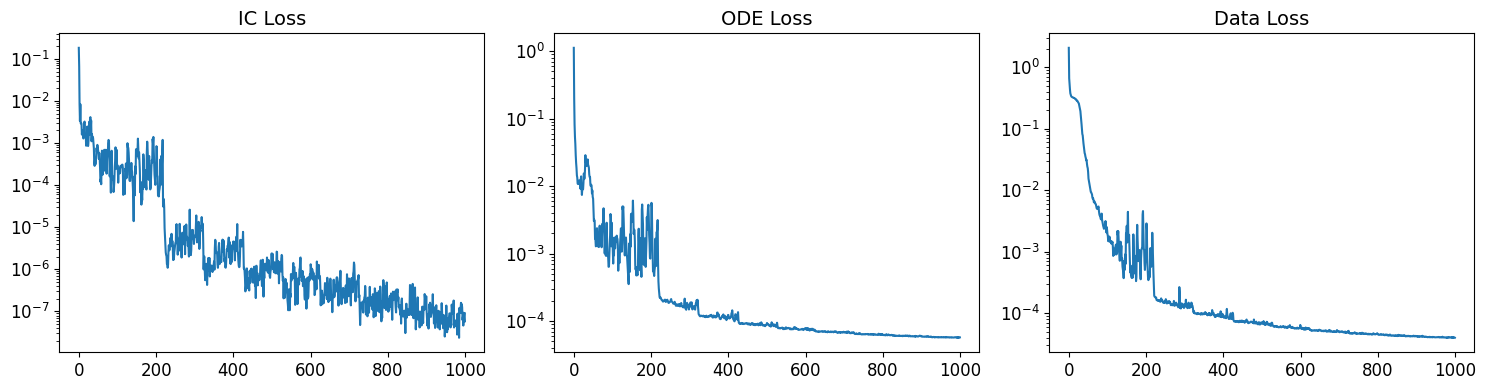

In [13]:
# History
%matplotlib inline
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(range(n_epochs), loss_tracker.loss_history['IC_loss'])
ax[1].plot(range(n_epochs), loss_tracker.loss_history['ODE_loss'])
ax[2].plot(range(n_epochs), loss_tracker.loss_history['Data_loss'])
ax[0].set_title('IC Loss', fontsize=14)
ax[1].set_title('ODE Loss', fontsize=14)
ax[2].set_title('Data Loss', fontsize=14)
for axs in ax:
    axs.set_yscale('log')
    axs.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()

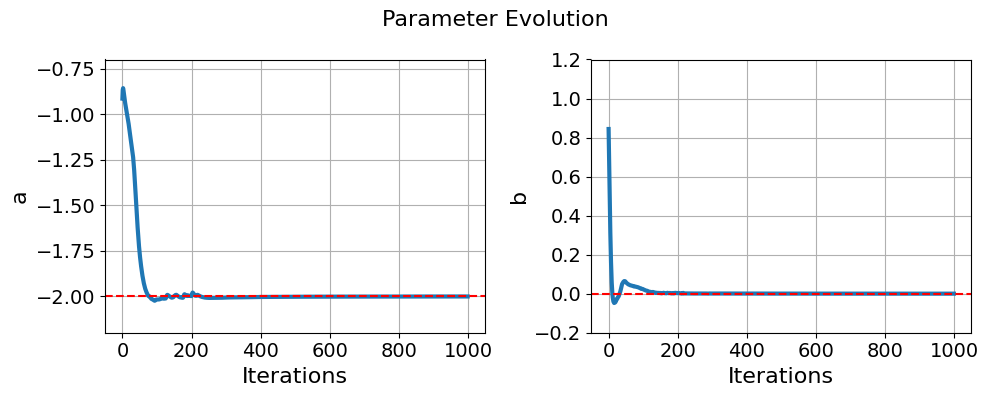

In [14]:
# Parameter history
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(range(n_epochs), a_list, lw=3)
ax[0].set_ylabel('a', fontsize=16)
ax[0].set_xlabel('Iterations', fontsize=16)
ax[0].set_ylim((-2.2, -0.7))
ax[0].axhline(y=-2, color='r', linestyle='--')

ax[1].plot(range(n_epochs), b_list, lw=3)
ax[1].set_ylabel('b', fontsize=16)
ax[1].set_xlabel('Iterations', fontsize=16)
ax[1].set_ylim((-0.2, 1.2))
ax[1].axhline(y=0, color='r', linestyle='--')

for axs in ax:
    axs.tick_params(axis='both', which='major', labelsize=14)
    axs.grid(True)
fig.suptitle('Parameter Evolution', fontsize=16)
plt.tight_layout()

#### Collect input/output of f-NN

In [15]:
t = np.linspace(0, 10, 10000).reshape(-1, 1)
u, f = PINN.predict(t, batch_size=12800)

# Configure dataframe
df = pd.DataFrame({
    't': t.flatten(),
    'u1': u[:, 0],
    'u2': u[:, 1],
    'u3': u[:, 2],
    'f1': f[:, 0],
    'f2': f[:, 1]
})
df.to_csv('f_NN_IO.csv', index=False)

1/1 [==============================] - 0s 36ms/step


Text(0.5, 1.0, 'f2')

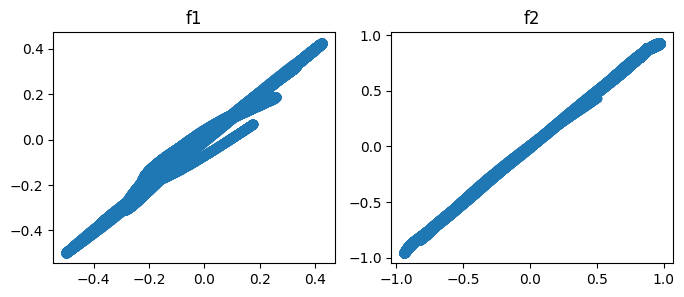

In [16]:
# Sanity check
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

ax[0].scatter(np.exp(-df.t.values/10)*df.u2.values*df.u3.values, df.f1)
ax[0].set_title('f1')

ax[1].scatter(df.u1.values*df.u3.values, df.f2)
ax[1].set_title('f2')

#### Assess accuracy: u prediction

In [17]:
t = np.linspace(0, 10, 5000).reshape(-1, 1)
pred_u, pred_f = PINN.predict(t, batch_size=12800)

1/1 [==============================] - 0s 31ms/step


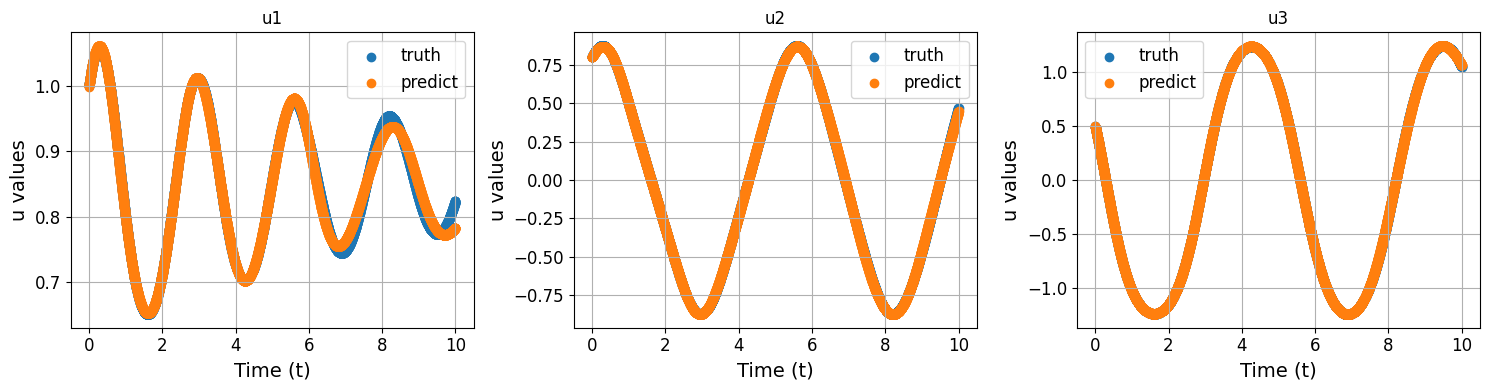

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ax[0].scatter(t.flatten(), y_test[:, 0], label='truth')
ax[0].scatter(t.flatten(), pred_u[:, 0], label='predict')
ax[0].set_title('u1')
ax[1].scatter(t.flatten(), y_test[:, 1], label='truth')
ax[1].scatter(t.flatten(), pred_u[:, 1], label='predict')
ax[1].set_title('u2')
ax[2].scatter(t.flatten(), y_test[:, 2], label='truth')
ax[2].scatter(t.flatten(), pred_u[:, 2], label='predict')
ax[2].set_title('u3')

for axs in ax:
    axs.set_xlabel('Time (t)', fontsize=14)
    axs.set_ylabel('u values', fontsize=14)
    axs.tick_params(axis='both', which='major', labelsize=12)
    axs.legend(fontsize=12, frameon=True)
    axs.grid(True)

plt.tight_layout()

#### Access accuracy: f prediction

In [19]:
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
with tf.GradientTape() as tape:
    tape.watch(X_test)
    u, f = PINN(X_test)

# Calculate gradients
dudt = tape.batch_jacobian(u, X_test)[:, :, 0]
du1_dt, du2_dt, du3_dt = dudt[:, :1], dudt[:, 1:2], dudt[:, 2:]

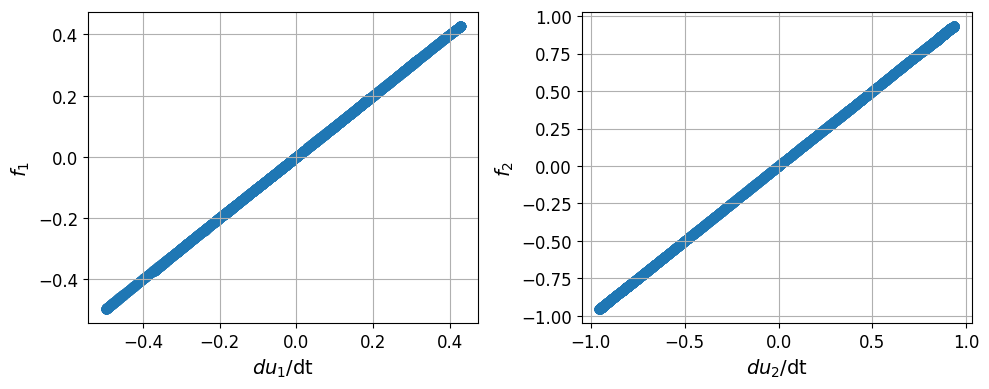

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].scatter(du1_dt.numpy().flatten(), f[:, 0].numpy())
ax[0].set_xlabel('$du_1$/dt', fontsize=14)
ax[0].set_ylabel('$f_1$', fontsize=14)
ax[1].scatter(du2_dt.numpy().flatten(), f[:, 1].numpy())
ax[1].set_xlabel('$du_2$/dt', fontsize=14)
ax[1].set_ylabel('$f_2$', fontsize=14)

for axs in ax:
    axs.tick_params(axis='both', which='major', labelsize=12)
    axs.grid(True)

plt.tight_layout()

# Symbolic Regression

In [21]:
!pip install pysr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 1.7 MB/s eta 0:00:00


In [22]:
from pysr import PySRRegressor
import pandas as pd

# Load dataset
df = pd.read_csv('/content/f_NN_IO.csv')

[juliapkg] Locating Julia ^1.6.1
[juliapkg] Querying Julia versions from https://julialang-s3.julialang.org/bin/versions.json
[juliapkg] WARNING: About to install Julia 1.10.2 to /root/.julia/environments/pyjuliapkg/pyjuliapkg/install.
[juliapkg]   If you use juliapkg in more than one environment, you are likely to have Julia
[juliapkg]   installed in multiple locations. It is recommended to install JuliaUp
[juliapkg]   (https://github.com/JuliaLang/juliaup) or Julia (https://julialang.org/downloads)
[juliapkg]   yourself.
[juliapkg] Downloading Julia from https://julialang-s3.julialang.org/bin/linux/x64/1.10/julia-1.10.2-linux-x86_64.tar.gz
             downloaded 99.9 MB of 161.8 MB
             download complete
[juliapkg] Verifying download
[juliapkg] Installing Julia 1.10.2 to /root/.julia/environments/pyjuliapkg/pyjuliapkg/install
[juliapkg] Using Julia 1.10.2 at /root/.julia/environments/pyjuliapkg/pyjuliapkg/install/bin/julia
[juliapkg] Using Julia project at /root/.julia/envir

In [25]:
df.head(10)

,t,u1,u2,u3,f1,f2
0,0.000000,0.999696,0.800049,0.500400,0.400939,0.440344
1,0.001000,1.000096,0.800490,0.498799,0.400007,0.439146
2,0.002000,1.000495,0.800930,0.497197,0.399071,0.437946
3,0.003000,1.000894,0.801369,0.495594,0.398132,0.436745
4,0.004000,1.001291,0.801806,0.493988,0.397189,0.435542
5,0.005001,1.001687,0.802243,0.492382,0.396243,0.434337
6,0.006001,1.002083,0.802678,0.490773,0.395293,0.433131
7,0.007001,1.002478,0.803111,0.489163,0.394340,0.431923
8,0.008001,1.002871,0.803544,0.487552,0.393383,0.430713
9,0.009001,1.003264,0.803976,0.485939,0.392422,0.429502


In [23]:
# Symbolic regression model
model = PySRRegressor(
    niterations=20,  # < Increase me for better results
    binary_operators=["+", "*"],
    unary_operators=[
        "cos",
        "exp",
        "sin",
        "inv(x) = 1/x",
    ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    loss="L1DistLoss()",
    model_selection="score",
    complexity_of_operators={
        "sin": 3, "cos": 3, "exp": 3,
        "inv(x) = 1/x": 3
    }
)

# NN for f1
X = df.iloc[:, :4].to_numpy()
f1 = df.loc[:, 'f1'].to_numpy()

model.fit(X, f1)

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:857: FutureWarning: loss has been renamed to elementwise_loss in PySRRegressor. Please use that instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1297: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 7.900e+02
Head worker occupation: 97.2%. This is high, and will prevent efficient resource usage. Increase `ncyclesperiteration` to reduce load on head worker.
Progress: 3 / 300 total iterations (1.000%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           2.014e-01  1.594e+01  y = -0.03497
3           1.371e-01  1.925e-01  y = (x₃ * x₂)
5           6.784e-02  3.517e-01  y = ((x₃ * x₂) * 0.68361)
7           6.640e-02  1.071e-02  y = ((0.52929 * (x₃ * x₂)) * 1.2296)
8           6.543e-02  1.473e-02  y = (x₃ * (x₂ * cos(0.91068)))
10          6.533e-02  7.094e-04  y = ((0.52929 * sin(x₃ * x₂)) * 1.2296)
13          6.522e-02  5.706e-04  y = sin((sin(0.52929) * (x₃ * x₂)) * 1.2296)
14          6.471e-02  7.935e-03  y = (sin(sin(sin(x₃ * x₂))) * 0.68361)
17          6.449e-02  1.122e-03  y = ((cos(cos(0.18275) * (x₃ * x₂)) * (x₃ * x₂)) * 0.6

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                        -0.02107861   
	1         0.191903                                          (x3 * x2)   
	2         0.369787                            ((x2 * x3) * 0.6132991)   
	3         0.003951          ((x3 * (x2 + -0.021173326)) * 0.63191724)   
	4         0.000012                        (sin(x3 * x2) * 0.63191724)   
	5         0.110604     (x3 * (x2 * (1.0003778 + (-0.11399094 * x0))))   
	6   >>>>  1.002972                (x3 * (x2 * exp(-0.10635711 * x0)))   
	7         0.009767  (x3 * (x2 * exp(-0.11399094 * (x0 + -0.2346462...   
	8         0.004878  sin(x3 * (x2 * exp(-0.117780805 * (x0 + -0.510...   
	9         0.009735  (x3 * (x2 * (sin(exp(-0.12999047 * x0)) * (1.2...   
	10        0.002281  ((x3 * 1.0763566) * (x2 * exp(-0.1507572 * (x0...   
	11        0.006937  ((x3 * 1.0763566) * (x2 * exp(-0.1507572 * (x0...   
	
	        loss  complexity  
	0   0.201200           1  
	1   0.137071           3  
	2   0.065426           5  
	3   0.064911           7  
	4   0.064910           8  
	5   0.058114           9  
	6   0.021315          10  
	7   0.020903          12  
	8   0.020599          15  
	9   0.020202          17  
	10  0.020156          18  
	11  0.019878          20  
]

In [26]:
X = df.iloc[:, :4].to_numpy()
f2 = df.loc[:, 'f2'].to_numpy()

model.fit(X, f2)

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1822: UserWarning: The discovered expressions are being reset. Please set `warm_start=True` if you wish to continue to start a search where you left off.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1297: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 2.130e+03
Head worker occupation: 0.1%
Progress: 6 / 300 total iterations (2.000%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.704e-01  1.594e+01  y = x₃
3           1.300e-02  1.287e+00  y = (x₃ * x₁)
5           1.236e-02  2.532e-02  y = ((x₃ * 0.99533) * x₁)
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 4.570e+03
Head worker occupation: 0.2%
Progress: 22 / 300 total iterations (7.333%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.704e-01  1.594e+01  y = x₃
3           1.300e-02  1.287e+00  y = (x₃ * x₁)
5           1.236e-02  2.532e-02  y = ((x₃ * 0.99533) * x₁)
1

PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                                 x3   
	1  >>>>  1.286630                                          (x3 * x1)   
	2        0.031950                           ((x3 * 0.99278754) * x1)   
	3        0.003896               ((x3 * x1) * cos(-0.025526183 * x0))   
	4        0.007880  ((x3 + ((0.015087071 * x3) * (-0.12290903 * x0...   
	5        0.009730        ((x3 * x1) * cos(-0.025526183 * (x0 + x2)))   
	6        0.005922  ((x3 * x1) * cos(-0.025526183 * (x0 + (x2 + -1...   
	7        0.005414  ((x3 * x1) * cos(-0.025526183 * (x0 + (x2 + (x...   
	8        0.024809  ((x3 * x1) * cos(-0.025526183 * ((cos(x0) * x3...   
	
	       loss  complexity  
	0  0.170414           1  
	1  0.013000           3  
	2  0.012196           5  
	3  0.011960          10  
	4  0.011866          11  
	5  0.011751          12  
	6  0.011613          14  
	7  0.011488          16  
	8  0.011207          17  
]